# Parkinson's Disease Speech Data Analysis
## Eric Hansen
### Flatiron Data Science Self Paced, 2020-2021, Phase 3 Project

Parkinson's Disease (aka Parkinson's) is a long-term degenerative disorder of the human nervous system.  Mainly affecting the motor system, patients with Parkinson's (PWP) have symptoms including tremor, slowness of movement, and difficulty walking and speaking.
Parkinson's affects approximately seven million people globally and one million people in the US.  Though it affects people much younger, the usual onset is later than age 60, rising from 1% in those 60 or older to 4% of the population over 80.
https://en.wikipedia.org/wiki/Parkinson's_disease

There exist certain diagnosis metrics (UPDRS) which measure a variety of different factors of patient behavior in order to diagnose Parkinson's.  These existing metrics include a measurement of speech impairment, but there is potential to improve upon this particular metric using a data scientific classification approach.  Ideally, this could be used to make earlier and more sensitive diagnoses than are currently the norm.  

# Source of Data: 

Erdogdu Sakar, B., Isenkul, M., Sakar, C.O., Sertbas, A., Gurgen, F., Delil, S., Apaydin, H., Kursun, O., 'Collection and Analysis of a Parkinson Speech Dataset with Multiple Types of Sound Recordings', IEEE Journal of Biomedical and Health Informatics, vol. 17(4), pp. 828-834, 2013.

As found on  
https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings#

And available    
https://www.researchgate.net/publication/260662600_Collection_and_Analysis_of_a_Parkinson_Speech_Dataset_With_Multiple_Types_of_Sound_Recordings

NB: The data found here are not raw sound files.  It has already been processed, filtered, and decomposed to extract numerous frequency, amplitude, and other metrics, which are found in this data set.

# Lots of imports

In [1]:
import sys
sys.version

'3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:20:24) [MSC v.1916 64 bit (AMD64)]'

In [2]:
#Verbose flag - turn True for additional reporting in following cells, turn False for more concise, shorter output.
verbose = False

In [3]:
use_default_cv=True
if use_default_cv:
    cv_def = 5
else:
    cv_def = None

In [4]:
#random_state handling
from random import randrange
is_random=False
if is_random:
    random_state_val = randrange(1, 500)
else:
    random_state_val = 7
if verbose:
    print('Random State Value Used this Run:', random_state_val)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
# Import the data
#training_target_df = pd.read_csv('data\Parkinson_Multiple_Sound_Recording\train_data.txt')

sample_descriptions = ['sust_a', 'sust_o', 'sust_u', 'num01', 'num02', 'num03', 'num04', 'num05', 'num06', 'num07', 'num08', 'num09', 
              'num10', 'sentence1', 'sentence2', 'sentence3', 'word1 through word9']
colheadings_train = ['ID', 
               'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
               'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
               'AC', 'NTH', 'HTN',
               'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
               'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period', 
               'fraction_of_locally_unvoiced_frames', 'num_voice_breaks', 'degree_of_voice_breaks',
                'UPDRS', 'class_info'
              ]
colheadings_test = ['ID', 
               'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
               'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
               'AC', 'NTH', 'HTN',
               'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
               'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period', 
               'fraction_of_locally_unvoiced_frames', 'num_voice_breaks', 'degree_of_voice_breaks',
               'class_info'
              ]
train_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/train_data.txt', sep=",", header=None, names=colheadings_train)
test_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/test_data.txt', sep=",", header=None, names=colheadings_test)
#training_df.columns = colheadings
#test_df = pd.read_csv('data\Parkinson_Multiple_Sound_Recording\test_data.txt', sep=",", header=None)
#st_unlabeled_df = pd.read_csv('data\Parkinson_Multiple_Sound_Recording\water_test-Copy1.csv')

In [7]:
# Train and test set classification inspection
train_df['class_info'].value_counts()

1    520
0    520
Name: class_info, dtype: int64

In [8]:
test_df['class_info'].value_counts()

1    168
Name: class_info, dtype: int64

Note that the training data is 50/50 Patients With Parkinsons (PWP) / non-PD patients, but the test data is 100% PWP.  
It may be more appropriate to consider cross-validation accuracy rates on the training set.  For the testset, we should consider alternative metrics.  We could try to oversample non-PD patients on the test set, but there aren't any.  

Upon further reflection, rather than keep the train/test separation that is given by the researchers, it will be better to combine them all into one data set, then train/test split ourselves.



In [9]:
combined_df = train_df.drop('UPDRS', axis=1).append(test_df)
combined_df['class_info'].value_counts()


1    688
0    520
Name: class_info, dtype: int64

In [10]:

#For use of code-flow, rename it
train_df = combined_df

Ultimately, which metric is appropriate for this setting?  If our goal were to be early detection or flagging in order to begin treatment, we'd want a metric that minimizes false negatives, at the risk of some false positives (which would have impact, but minimal impact, unless it lead to an erroneous treatment that may have side effects, but hopefully those could be counteracted by further testing).  Recall is a good candidate for primary metric here, though we may also still take a look at accuracy and f1 for additional perspective.

# Definitions  

For each patient, several voice samples are taken, then 26 features are extracted using commonly used analysis of those samples.  

"In this context, during medical ex-aminations, each subject is asked to read or say predetermined26 voice samples containing numbers from 1 to 10, four rhymedsentences, nine words in Turkish language along with sustainedvowels “a”, “o”, and “u.” To extract features from voice samples,Praat acoustic analysis software is used. A group of 26 linearand time-frequency based features are extracted fromeach voice sample considering the previous works held on this ﬁeld of study."  

(Sources for following: https://www.sciencedirect.com/science/article/pii/S2212017313002788   
https://www.fon.hum.uva.nl/praat/manual/Voice_2__Jitter.html  
)  

## Frequency parameters
Jitter is a measure that reflects the variation of the successive periods; analysis estimates the underlying timing of the fundamental period.  It is a frequency variation metric.

Jitter (local): Represents the average absolute difference between two consecutive periods, divided by the 
average period.  

Jitter (local, abs): Represents the average absolute difference between two consecutive periods.  

Jitter (rap): Represents the average for the disturbance, i.e., the average absolute difference of one period 
and the average of the period with its two neighbors, divided by the average period.  

Jitter (ppq5): Represents the ratio of disturbance within five periods, i.e., the average absolute difference 
between a period and the average containing its four nearest neighbor periods, i.e. two previous and two 
subsequent periods, divided by average period.  

Jitter (ddp): This is the average absolute difference between consecutive differences between consecutive periods, divided by the average period.  

## Amplitude Parameters
Shimmer is a measure that reflects variation of the amplitude over time; it is an amplitude variation metric, with respect to the maximum peak amplitude.  

Shimmer (local): Represents the average absolute difference between the amplitudes of two consecutive 
periods, divided by the average amplitude. 

Shimmer (local, dB): Represents the average absolute difference of the base 10 logarithm of the difference 
between two consecutive periods.  

Shimmer (apq3): represents the quotient of amplitude disturbance within three periods, in other words, the 
average absolute difference between the amplitude of a period and the mean amplitudes of its two neighbors, 
divided by the average amplitude. 

Shimmer (apq5): Represents the ratio of perturbation amplitude of five periods, in other words, the average 
absolute difference between the amplitude of a period and the mean amplitudes of it and its four nearest 
neighbors, divided by the average amplitude. 

## Harmonicity Parameters
HTN: Harmonic to noise ratio.  (I would interpret this as a measure of the "purity" of pitch, relative to extraneous pitches).
ratio of ACfundamental to difference between ACfundamental and ACfirst harmonic.
NTH:  Noise to Harmonic ratio.  

AC: Autocorrelation - in general, a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals; i.e., the correlation of a signal with itself in later time periods. (In this case, this may be adjusted to have to do with the value of the first peak of the period graph - represents the fundamental frequency; used in HTN and NTH)

## Pitch Parameters
Pitch: how the human ear perceives sound frequencies - e.g. high/low.  The note or tone or sound frequency.
Median Pitch, mean pitch, std_dev, min_pitch, max_pitch: descriptive stats for pitch.

## Pulse parameters
Period: in general, the reciprocal of frequency - the length in time of one cycle.  In context of pulse, however, this may have additional connotation.
Pulse: in general, a rapid, transient change from a baseline signal to a different value, followed by a rapid return to baseline.  
Num_pulses, num_periods, mean_period, std_dev_of_period: descriptives for period

## Voicing Parameters
(source: https://fon.hum.uva.nl/praat/manual/Voice_1__Voice_breaks.html)  
fraction_of_locally_unvoiced_frames: This is the fraction of pitch frames that are analysed as unvoiced; subject to a pitch floor.

Number of voice breaks: The number of distances between consecutive pulses that are longer than 1.25 divided by the pitch floor. Thus, if the pitch floor is 75 Hz, all inter-pulse intervals longer than 16.6667 milliseconds are regarded as voice breaks.

Degree of voice breaks: This is the total duration of the breaks between the voiced parts of the signal, divided by the total duration of the analysed part of the signal 


UPDRS: Uniﬁed Parkinson’s Disease Rating Scale; inconsistent between train/test set, so unused.  
    See https://www.theracycle.com/resources/links-and-additional-resources/updrs-scale/ for details

Class_info: target column, whether or not the patient has Parkinson's Disease


# Discussion:
Some potential engineered features include binning for some numerical values.
One useful feature to have would be gender, (of course, ultimately we would refine the process to take into account people who are transgender, intersex et al); since we aren't given that, we may be able to estimate that using pitch features.  There are a variety of studies that investigate pitch as a predictor, while others others indicate timbre as a predictor.  Since our data includes pitch, we will work with that.

In discussion with a speech pathologist, one major indicator of PD is oral festination.  Another indicator is speaking in monotone.

"In Parkinson's disease (PD), festination corresponds to a tendency to speed up when performing repetitive movements. First described in gait (and then in handwriting and speech), festination is one of the most disabling axial symptoms" - https://pubmed.ncbi.nlm.nih.gov/17516477/

These indicator doesn't seem to be represented directly from existing features; however, may be able to be engineered, or, failing that, we may recognize in the parameters of our final models some representative of these indicators.

# Exploratory Data Analysis

In [11]:
train_df.head()

,ID,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_dB,shimmer_apq3,shimmer_apq5,...,min_pitch,max_pitch,num_pulses,num_periods,mean_period,std_dev_of_period,fraction_of_locally_unvoiced_frames,num_voice_breaks,degree_of_voice_breaks,class_info
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,142.229,187.576,160.0,159.0,0.006065,0.000416,0.000,0.0,0.000,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,159.515,234.505,170.0,169.0,0.005181,0.000403,2.247,0.0,0.000,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,146.445,211.442,1431.0,1427.0,0.006071,0.000474,10.656,1.0,0.178,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,182.713,220.230,94.0,92.0,0.004910,0.000320,0.000,0.0,0.000,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,182.821,225.162,117.0,114.0,0.004757,0.000380,18.182,1.0,13.318,1


In [12]:
print(f'{train_df.shape[0]} samples and {train_df.shape[1]} features in the Parkinsons Disease dataset.')

1208 samples and 28 features in the Parkinsons Disease dataset.


In [13]:
#Some basic data integrity checks 
if verbose:
    display(train_df.groupby('ID').count().head())
    display(train_df.groupby('class_info').max().head())
    display(train_df.groupby('class_info').min().head())
    display(train_df.groupby('class_info').count().head())
    display(train_df['class_info'].value_counts())

In [14]:
if verbose:
    test_df.head()

In [15]:
# Data Type inspection
if verbose:
    display(train_df.head())
    display(train_df.info())

In [16]:
#N/A check
if verbose:
    train_df.isna().sum()

In [17]:
#UPDRS and class info correlation check
if verbose: 
    #display(train_df['UPDRS'].value_counts())  #UPDRS only appeared in train set, so we have removed it
    display(train_df['class_info'].value_counts())

# Metrics  
Let's define some metrics - the usuals, plus a new one mentioned in the research paper that provided this data, namely MCC (Matthews Correlation Coefficient). 

Note that many of these are already implemented into many of the models we use, but I will provide these here just in case they're needed in a pinch.

Also, among the other usual suspects, recall will be at a premium here because it better represents when costs of False Negatives are high (i.e. if we miss a PWP, that is a significant problem; moreso than a false positive).


In [18]:
def precision(y, y_hat):
    # Your code here
    # precision = true positives / all predicted positives
#     resid = y-y_hat
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1    
    return cmatrix['TP']/(cmatrix['TP']+cmatrix['FP'])
    
    
def recall(y, y_hat):
    # Your code here
    # recall = true pos / actual total positives
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1    
    return cmatrix['TP']/(cmatrix['TP']+cmatrix['FN'])

def accuracy(y, y_hat):
    # Your code here
    # accuracy  = (number of true pos + true neg)/ total obs
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1    
    return (cmatrix['TP']+cmatrix['TN'])/len(y)

def f1_score(y, y_hat):
    # Your code here
    # 2(precision*recall)/(precision+recall)
    prec = precision(y, y_hat)
    rec = recall(y, y_hat)
    return 2*(prec*rec)/(prec+rec)

def mcc(y, y_hat):
    #This is also known as Matthews Correlation Coefficient
    #MCC =(TPxTN −FPxFN) / sqrt((TP +FP)(TP +FN)(TN +FP)(TN +FN))
    #### This metric does have issues when there are no negatives in the set - namely, in the test set we were originally given####
    
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1
    TP = cmatrix['TP']
    TN = cmatrix['TN']
    FP = cmatrix['FP']
    FN = cmatrix['FN']
    return ((TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))

def score_suite(y, y_hat):
    results = []
    testnames = ['precision', 'recall', 'accuracy', 'f1_score', 'mcc']
    tests = [precision, recall, accuracy, f1_score, mcc]
    for test in tests:
        results.append(test(y,y_hat))
    return [testnames, results]
#score_suite(y_train, y_pred)

Furthermore, let's import and use the built in classification report and confusion matrix tools.

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
#metrics.classification_report(y_true, y_pred, *)
#metrics.confusion_matrix(y_true, y_pred, *)
def report(y_true, y_pred, name):
    '''combination of two metric reports, formatted to include train vs test name'''
    print("----Report for {} set----".format(name))
    print('--Common metric scores:')
    print(classification_report(y_true, y_pred))
    print('--Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred, normalize='all'))
    print('------------------------------------------')
    
#report(y_train, y_preds, 'Train')
#report(y_test, y_test_pred, 'Test')


# Initial inspection of predictor/target variables  
Since the target variable is binary, scatter plot isn't much use, but we can do a distribution plot of all the predictors to see how they are arranged.

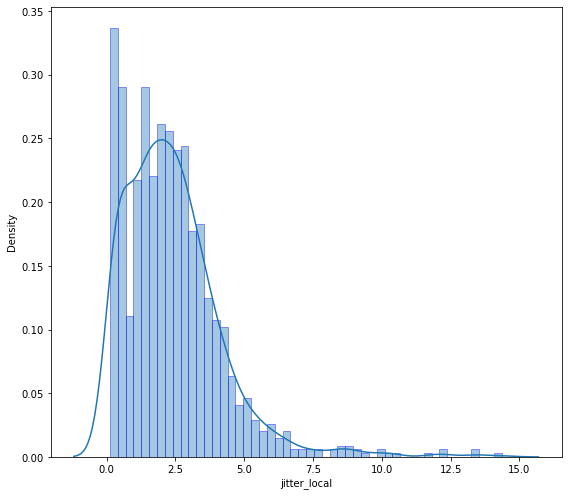

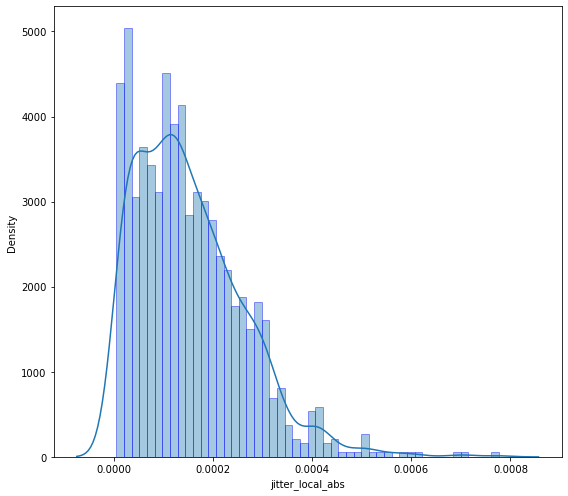

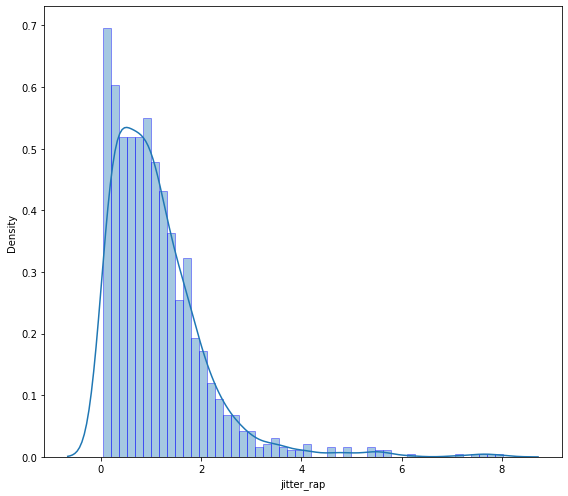

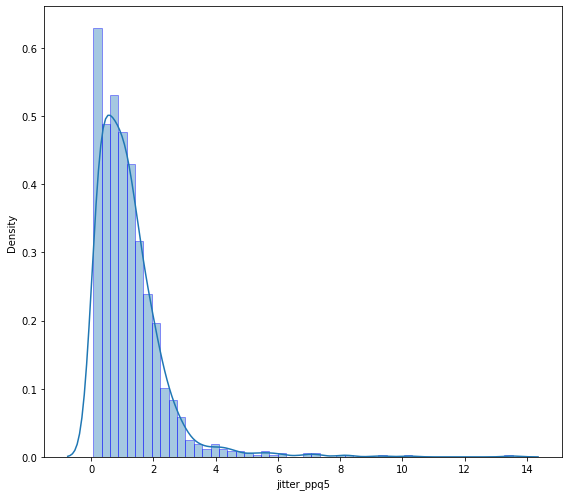

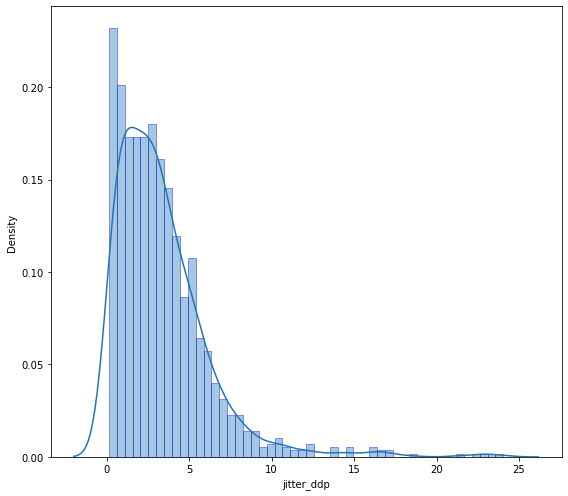

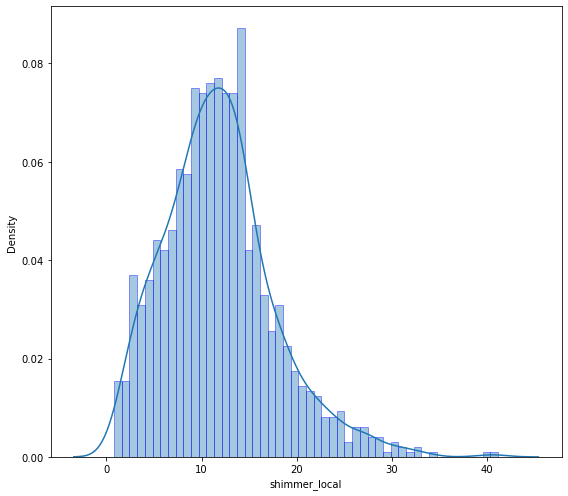

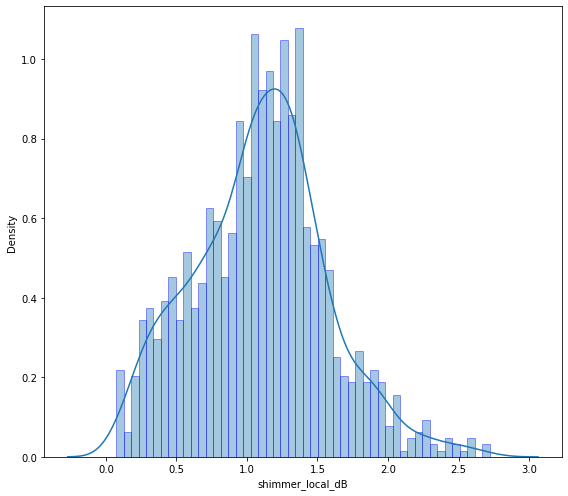

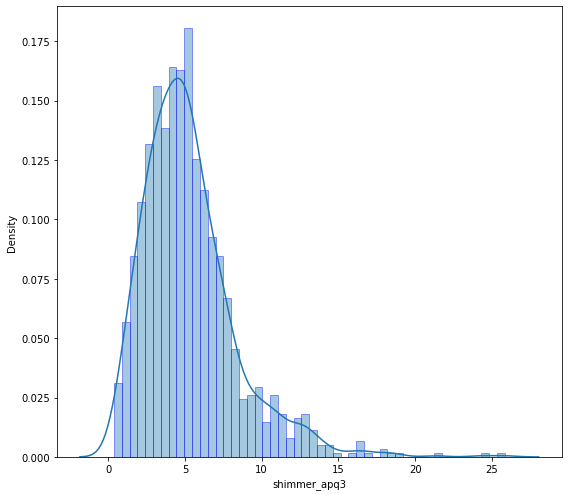

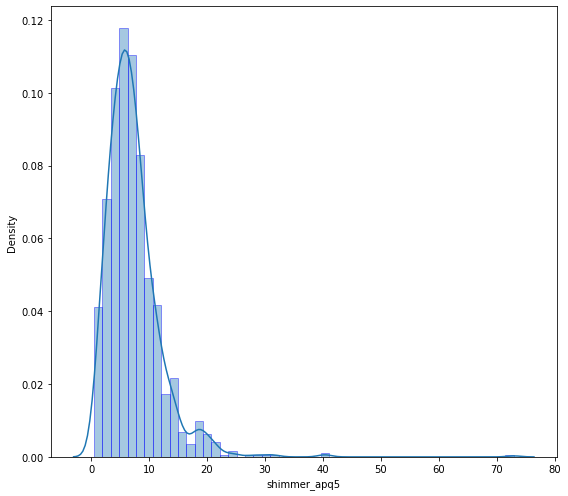

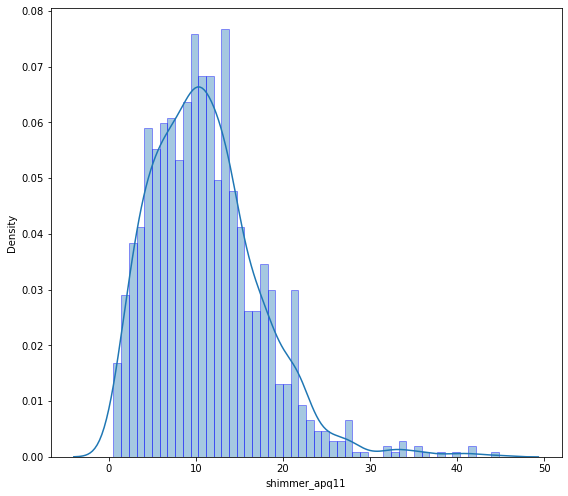

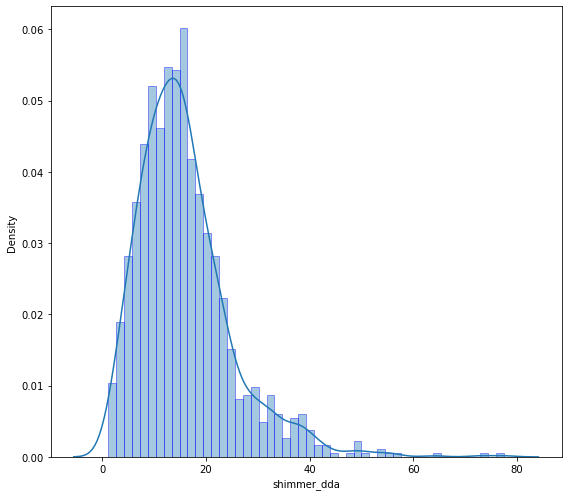

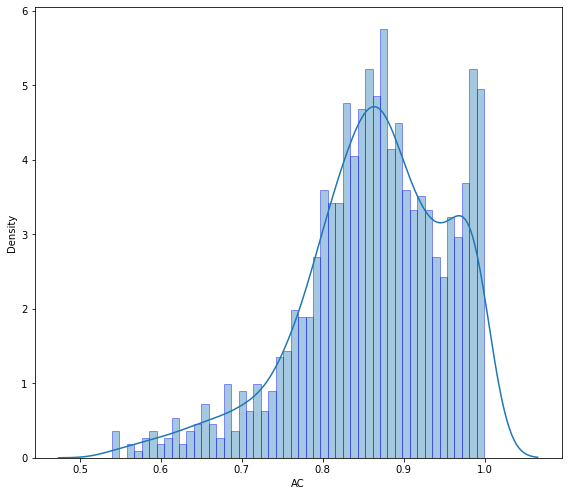

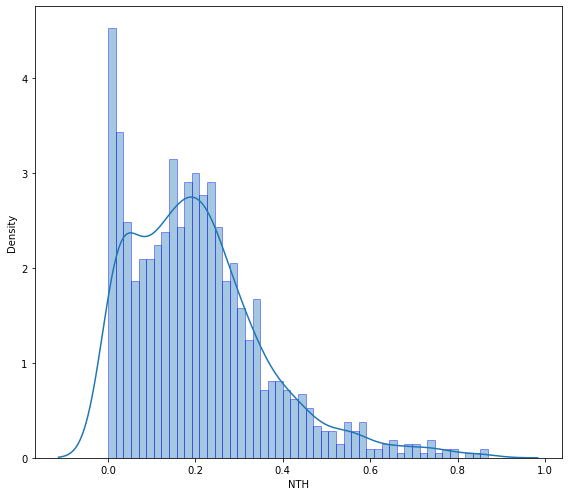

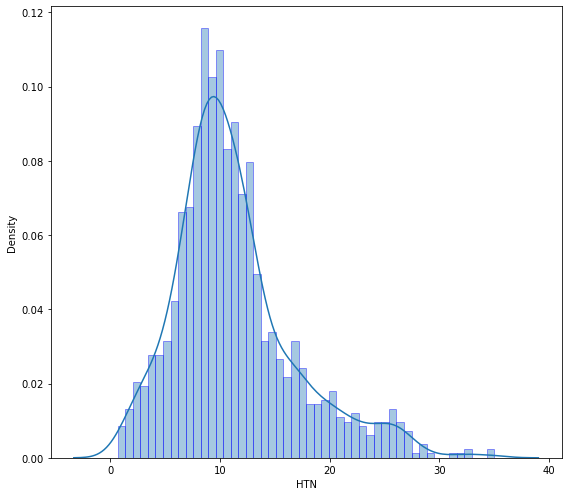

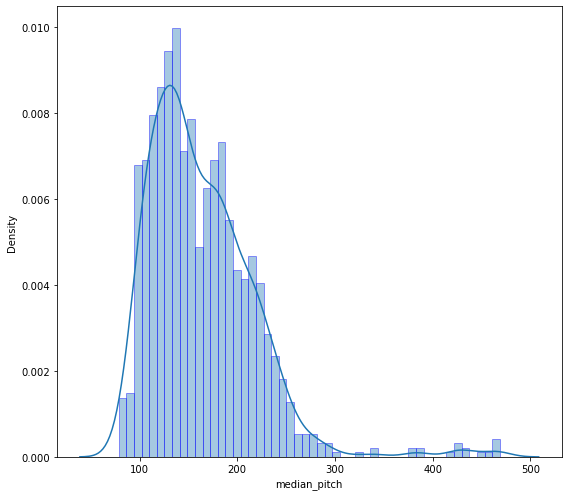

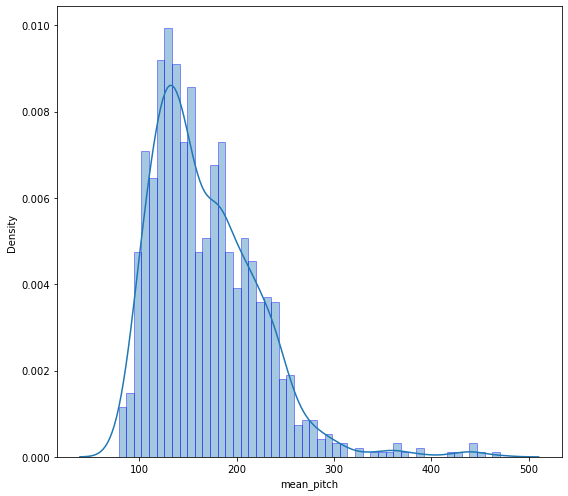

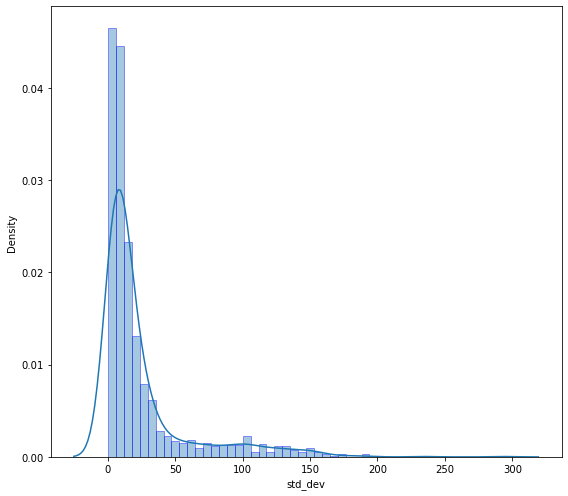

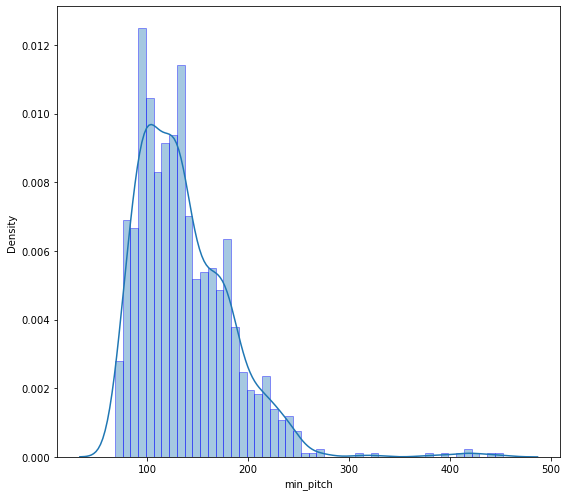

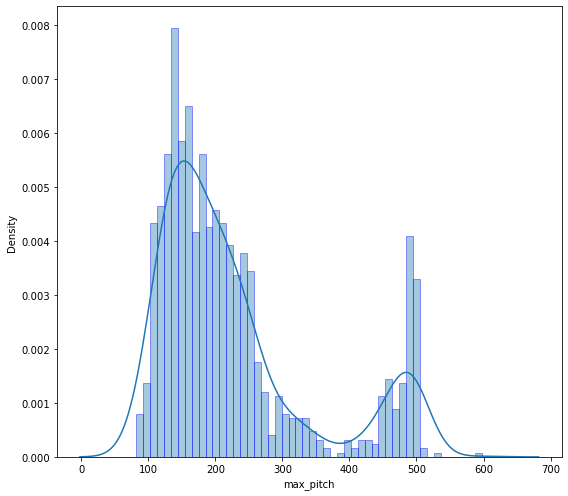

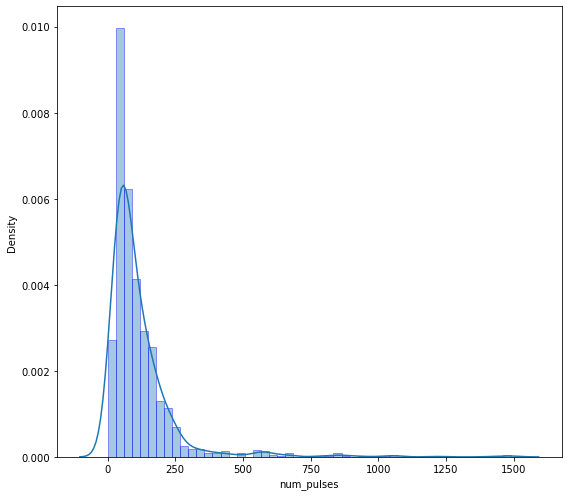

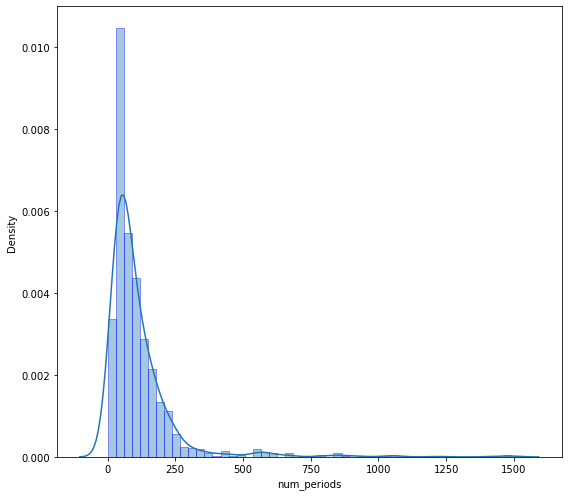

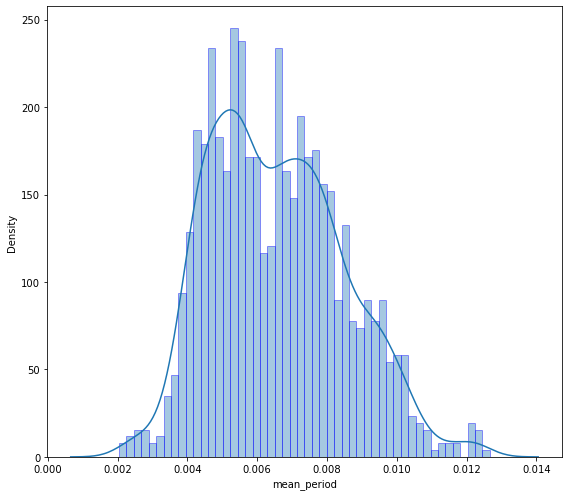

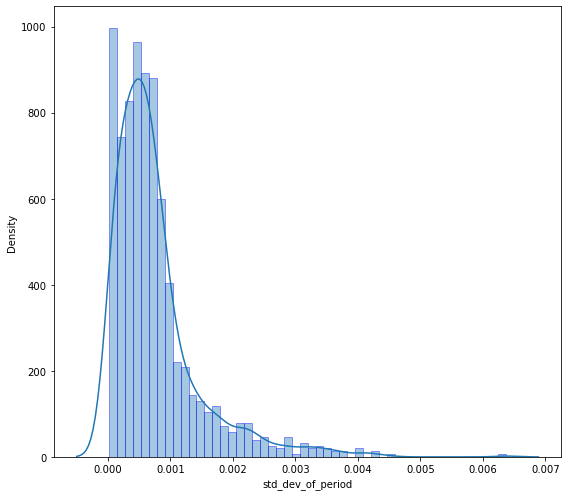

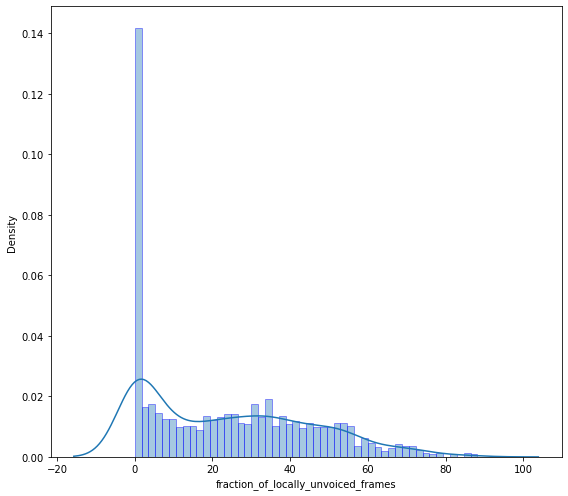

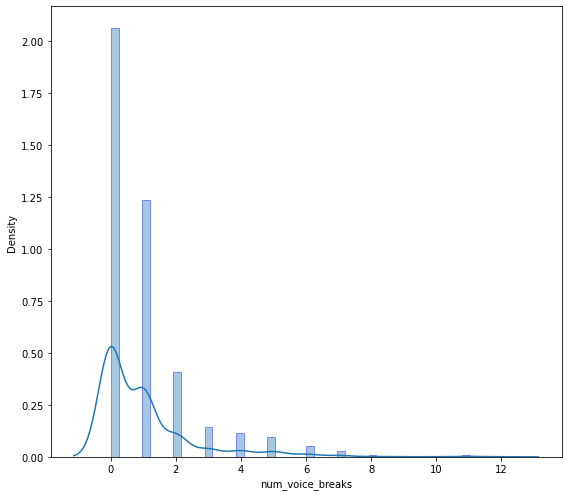

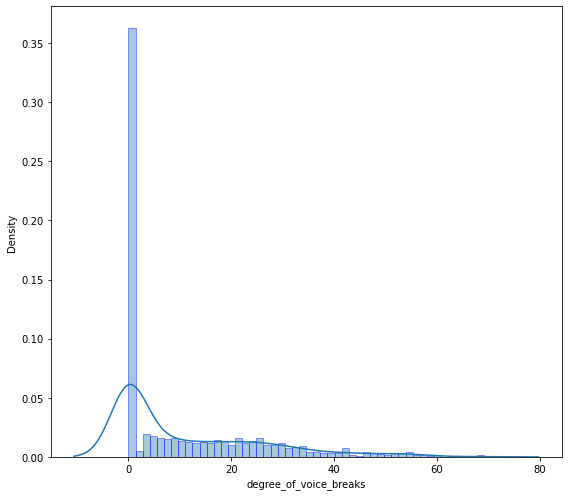

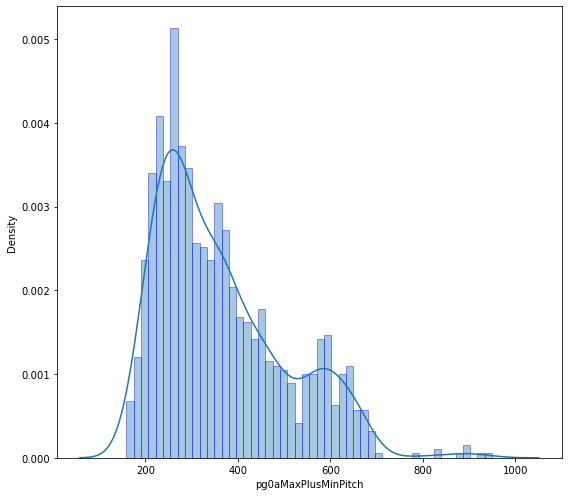

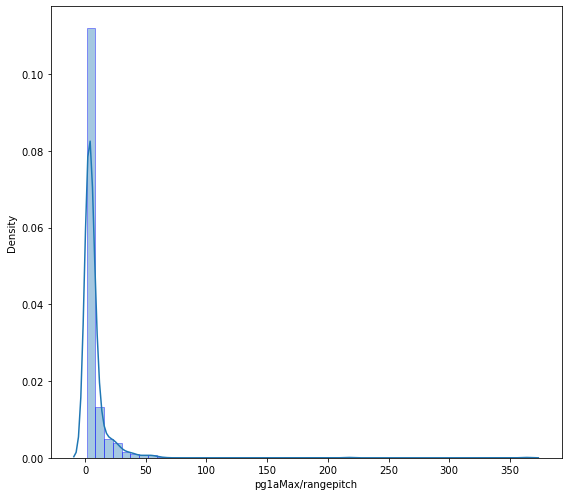

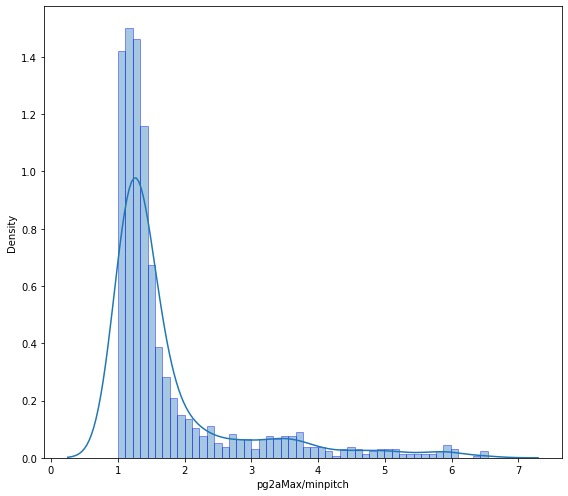

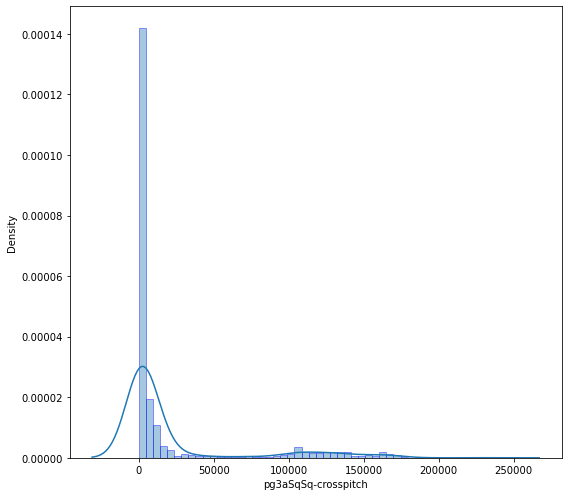

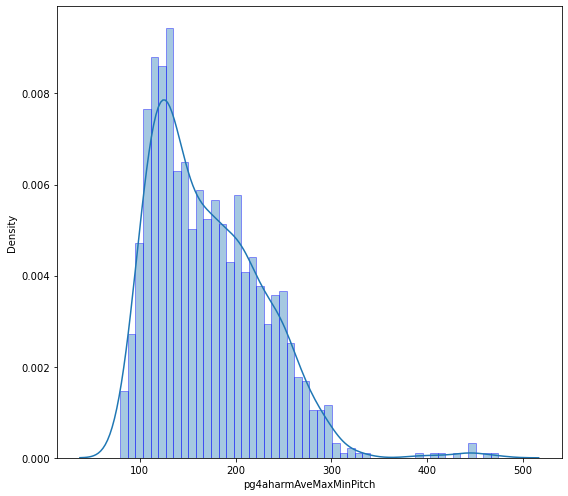

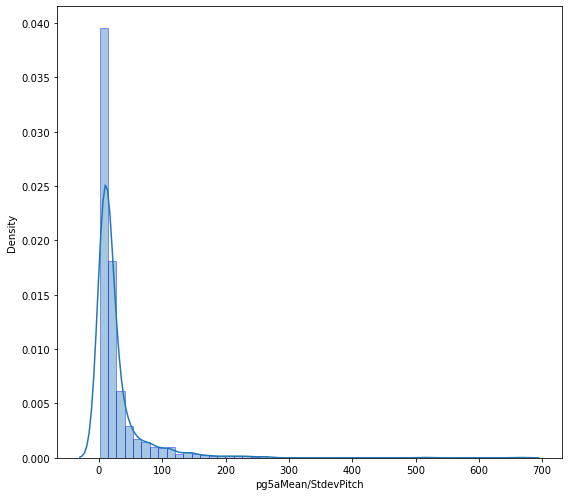

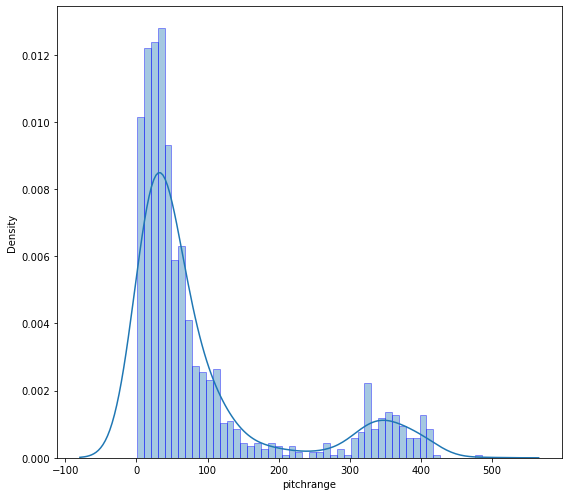

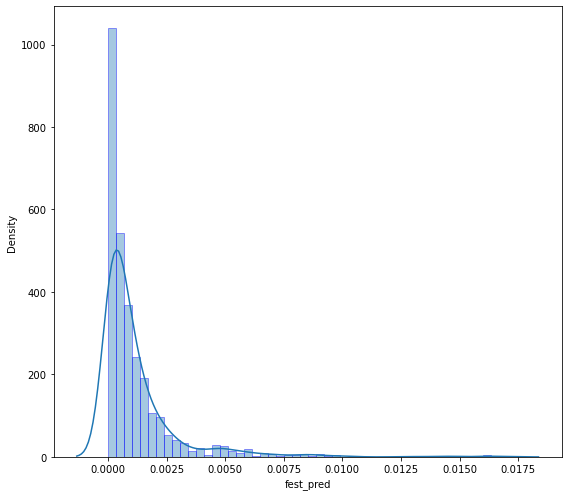

In [235]:
X = train_df.drop(['class_info', 'ID'], axis=1)
y = train_df['class_info']
target = 'class_info'
df = train_df

# plt.figure(figsize=(9, 5))
# col = 'jitter_local'
# sns.scatterplot(x=col, y=target, data=df).set_title('{} vs. {} EXAMPLE'.format(col, target))
# plt.ticklabel_format(style='plain')#style='plain', 'sci', 'scientific'

if verbose:
#if True:
    for col in X.columns:
    #for col in ['jitter_local']:
        #scatter plots for each
        #plt.figure(figsize=(9, 5))
        #note that this plot is basically not helpful for binary categorization
        #sns.scatterplot(x=col, y=target, data=train_df).set_title('{} vs. {}'.format(col, target))
        #plt.ticklabel_format(style='plain')#style='plain', 'sci', 'scientific'

    #     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #     axes[0].set_title('{} Count'.format(col))
    #     sns.countplot(df[col], ax=axes[0], color='purple')
    #     axes[1].set_title('{} vs. {}'.format(col, target))
    #     sns.boxplot(x=col, y=target, data=df, ax=axes[1])

        plt.figure(figsize=(8, 7))
        sns.distplot(train_df[col], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
        plt.ticklabel_format(style='plain')


        plt.tight_layout()

In [21]:
#if verbose:
display(y.value_counts())

1    688
0    520
Name: class_info, dtype: int64

## Boxplots of each predictor variable

,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_dB,shimmer_apq3,shimmer_apq5,shimmer_apq11,...,min_pitch,max_pitch,num_pulses,num_periods,mean_period,std_dev_of_period,fraction_of_locally_unvoiced_frames,num_voice_breaks,degree_of_voice_breaks,class_info
0,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,6.802,...,142.229,187.576,160.0,159.0,0.006065,0.000416,0.000,0.0,0.000,1
1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,7.194,...,159.515,234.505,170.0,169.0,0.005181,0.000403,2.247,0.0,0.000,1
2,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,7.548,...,146.445,211.442,1431.0,1427.0,0.006071,0.000474,10.656,1.0,0.178,1
3,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,16.779,...,182.713,220.230,94.0,92.0,0.004910,0.000320,0.000,0.0,0.000,1
4,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,12.823,...,182.821,225.162,117.0,114.0,0.004757,0.000380,18.182,1.0,13.318,1


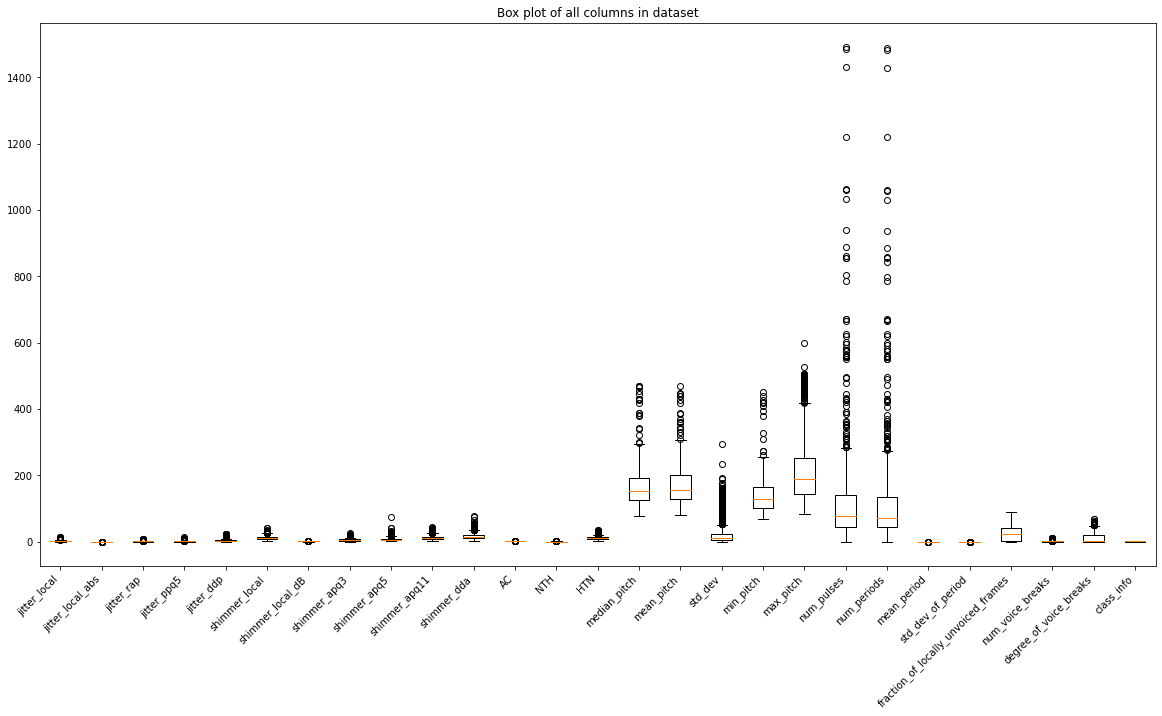

In [22]:
numcols = ['jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5',
       'jitter_ddp', 'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3',
       'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda', 'AC', 'NTH', 'HTN',
       'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
       'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period',
       'fraction_of_locally_unvoiced_frames', 'num_voice_breaks',
       'degree_of_voice_breaks', 'class_info']
df_box = df[numcols]
display(df_box.head())
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=45, ha='right')
plt.boxplot([df_box[col] for col in df_box.columns])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(1, len(df_box.columns.values)+1), df_box.columns.values, rotation=45, ha='right')
plt.show()

### Putting everything on the same scale here isn't so illuminating; let's split things up.

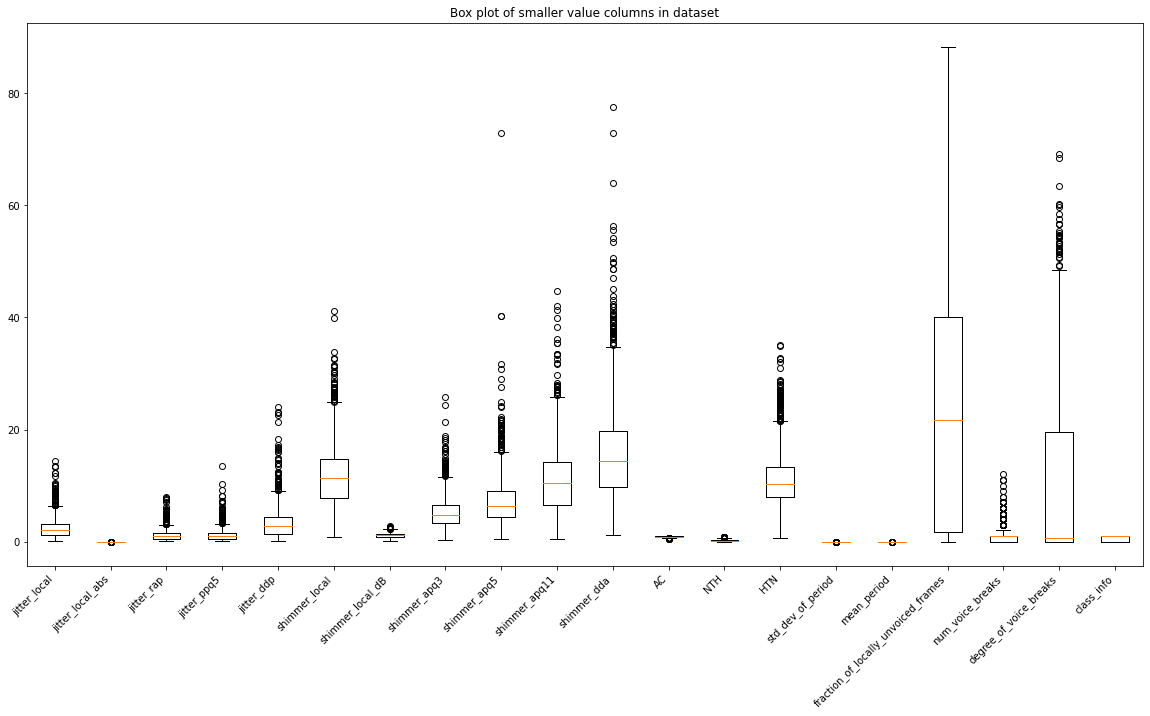

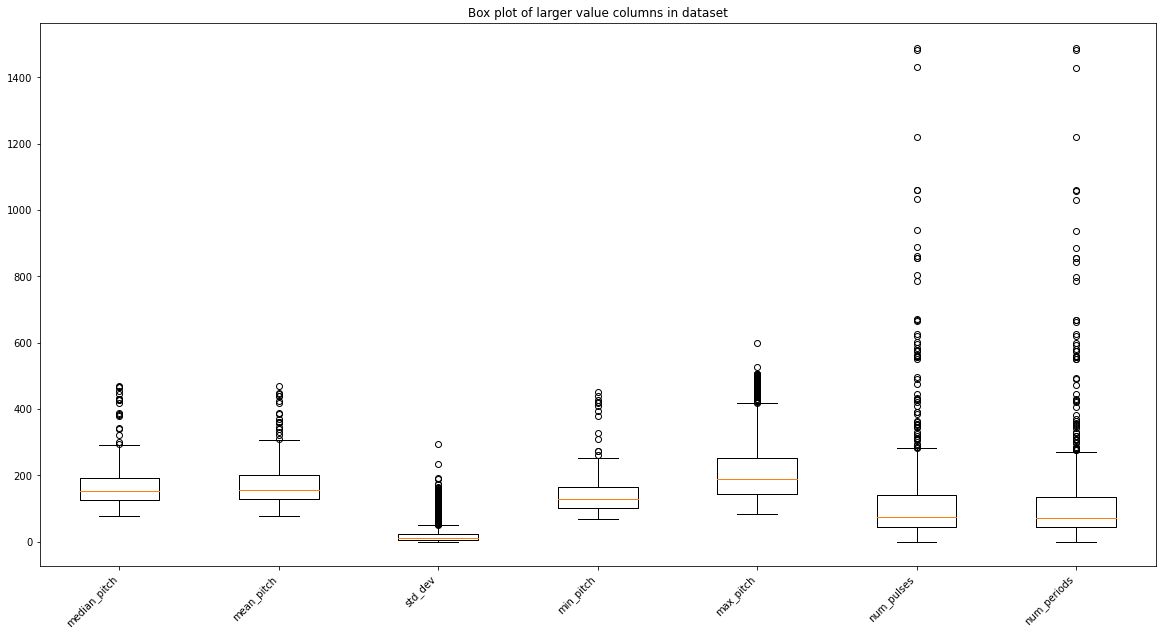

In [23]:
numcols1 = [ 'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5',
       'jitter_ddp', 'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3',
       'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda', 'AC', 'NTH', 'HTN',
       'std_dev_of_period','mean_period',
       'fraction_of_locally_unvoiced_frames', 'num_voice_breaks',
       'degree_of_voice_breaks', 'class_info']
numcols2 = [ 'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
       'num_pulses', 'num_periods', ]
df_box = df[numcols1]
#display(df_box.head())
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
plt.boxplot([df_box[col] for col in df_box.columns])
plt.title("Box plot of smaller value columns in dataset")
plt.xticks(range(1, 1+len(df_box.columns.values)), df_box.columns.values)
plt.show()

df_box = df[numcols2]
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
plt.boxplot([df_box[col] for col in df_box.columns])
plt.title("Box plot of larger value columns in dataset")
plt.xticks(range(1, 1+len(df_box.columns.values)), df_box.columns.values)
plt.show()

In [24]:
#A little deeper look at some of those with lots of outliers
display(df['fraction_of_locally_unvoiced_frames'].describe())
display(df['mean_period'].describe())
display(df['shimmer_dda'].describe())
display(df['num_pulses'].describe())
display(df['num_periods'].describe())

count    1208.000000
mean       23.939627
std        21.594252
min         0.000000
25%         1.762250
50%        21.672500
75%        40.000000
max        88.158000
Name: fraction_of_locally_unvoiced_frames, dtype: float64

count    1208.000000
mean        0.006563
std         0.001910
min         0.002039
25%         0.005040
50%         0.006456
75%         0.007870
max         0.012669
Name: mean_period, dtype: float64

count    1208.000000
mean       15.838735
std         9.181708
min         1.143000
25%         9.800250
50%        14.383000
75%        19.802000
max        77.459000
Name: shimmer_dda, dtype: float64

count    1208.000000
mean      116.399834
std       141.265900
min         0.000000
25%        45.000000
50%        76.000000
75%       140.250000
max      1490.000000
Name: num_pulses, dtype: float64

count    1208.000000
mean      112.910596
std       140.805325
min         0.000000
25%        43.000000
50%        72.000000
75%       135.250000
max      1489.000000
Name: num_periods, dtype: float64

Fraction of L.U.F. is a percentage, so ranges 0 to 100.  Just be careful about any possible log scaling on it.  The others just have substantial outlier variance.  Since we have enough other predictors, and our various tree and gradient methods should be able to ignore any problematic extra predictors, we will proceed as is for now.

# Initial Un-tuned Decision Tree Classifier, just to see some feature importances.

In [25]:
#preliminary train/test split before adding any new features
X = train_df.drop(['class_info', 'ID'], axis=1)
y = train_df['class_info']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=random_state_val)

In [26]:
#A rather useful plotting function for feature importances for a model
##this is the unsorted function - the cell after this contains the improved function
# def plot_feature_importances(model):
#     '''plot feature importances for argument model, as long as model has .feature_importances_ defined.
#     Examples would be decision tree or random forest models'''
#     n_features = X_train.shape[1]
#     plt.figure(figsize=(8,8))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), X_train.columns.values) 
#     plt.xlabel('Feature importance')
#     plt.ylabel('Feature')
    
# def zip_feature_importances(model, X):
#     return sorted(zip(model.feature_importances_, X.columns.values))


In [27]:
#A rather useful plotting function for feature importances for a model
def zip_feature_importances(model, X):
    #return(sorted(sub_li, key = lambda x: x[1])) 
    return sorted(zip(model.feature_importances_, X.columns.values), key = lambda x: x[0])
#print(zip_feature_importances(dt_clf, X_train)) #testing

def plot_feature_importances(model):
    '''plot feature importances for argument model, as long as model has .feature_importances_ defined.
    Examples would be decision tree or random forest models'''
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    x = range(n_features)
    y = model.feature_importances_
    sorted_vals = zip_feature_importances(model, X_train)
    sorted_features = []
    sorted_scores = []
    for s, f in sorted_vals:
        sorted_features.append(f)
        sorted_scores.append(s)
    
    #x, y = zip_feature_importances(model, X_train)
    
    plt.barh(sorted_features, sorted_scores, align='center') 
    plt.yticks(np.arange(n_features), sorted_features) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

Mean Cross Validation Score for DT: 66.56%
Fitted Score for DT training set:  1.0
Recall Score for DT test set:  0.7189189189189189


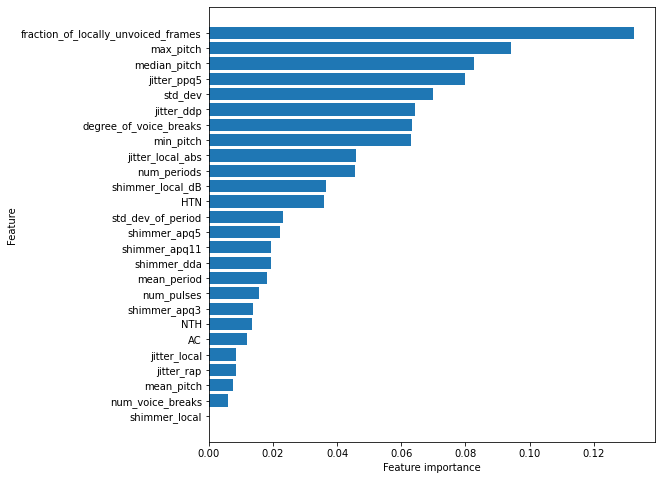

In [28]:
# Initial decision tree! 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier #come back for Adaboost?
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=random_state_val)
scoring_p='accuracy'#None #'recall' #or None
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=cv_def, scoring = scoring_p)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score for DT: {mean_dt_cv_score :.2%}")

dt_clf.fit(X_train, y_train)
y_preds = dt_clf.predict(X_train)
print("Fitted Score for DT training set: ", recall(y_preds, y_train))
y_test_preds = dt_clf.predict(X_test)
print("Recall Score for DT test set: ", recall(y_test_preds, y_test))


#print(dt_clf.get_params())
#print(dt_clf.feature_importances_)

plot_feature_importances(dt_clf)
############################################################


In [29]:
report(y_train, y_preds, 'Train')
report(y_test, y_test_preds, 'Test')


----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       512

    accuracy                           1.00       906
   macro avg       1.00      1.00      1.00       906
weighted avg       1.00      1.00      1.00       906

--Confusion Matrix:
[[0.43487859 0.        ]
 [0.         0.56512141]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       126
           1       0.72      0.76      0.74       176

    accuracy                           0.69       302
   macro avg       0.68      0.67      0.67       302
weighted avg       0.68      0.69      0.68       302

--Confusion Matrix:
[[0.24503311 0.17218543]
 [0.14238411 0.44039735]]
------------------------------------------


# ---Feature Engineering---

# Repeated patient data leakage caveat
Initially in analysis, some features I engineered took into account the max/min across ID values.  This gave very good results!  However, I then realized that there was effectively data leakage within the cross-validation process, since some lines for a given ID (even when dropping the ID column itself) would be used for training and then again in validation.  This repeated data is inherently troublesome because of the possibility to overfit for these repeated patients.  

Strategies to address this: 
1) manually reserve some percentage of ID values to use as a validation set.  
2) avoid doing any feature engineering that groups by ID value.  
While 1 is attractive, it's probably a better long-term approach to use 2.  In part, this would be more realistic in practice, since a diagnostic test would be more easily administered with just one battery of voice samples, not repeating the same test multiple times.  

Another approach would be to do -both-.  This could be the focus of a later analysis.

# Gender/Sex features    
From our data, "The data collected in the context of this study (Fig. 1) belongs to 20 PWP (6 female, 14 male) and 20 healthy individuals (10 female, 10 male) who appealed at the Department of Neurologyin Cerrahpas¸a Faculty of Medicine, Istanbul University."
Reports (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2117736/) state that PD is 1.5-2 times more common in males than females, so this could be an important feature to acquire.  Biological sex is, however, separate from gender expression (which voice pitch would be more indicative of).  Ethically, we'd strive to achieve equity in engineering features and modelling, while making a model that was optimally accurate for health outcomes.  

Since there appears to be bi-modality in pitch distributions, this indicates gender predictability; 
but some overlap in pitch curves, we will try to engineer a few more discerning features.  
Max pitch does seem to have the most disjoint distribution, we can use that as a starting point.

Initially, I thought to make a binary feature for this, by calculating a number, then comparing it against a mean threshold value; but on later reflection, decided to leave the numerical feature and let the models optimize whatever predictive power these features have.

In [30]:
train_df[['max_pitch', 'min_pitch']].describe()
#train_ID_grp['max_pitch'].max()

,max_pitch,min_pitch
count,1208.000000,1208.000000
mean,226.325135,136.905805
std,116.194257,47.720770
min,82.171000,67.957000
25%,143.578750,101.037000
50%,188.932000,128.195000
75%,253.318250,164.124250
max,597.974000,452.083000


In [31]:
#Initial approach, not used, grouping by ID then using aggregation functions

##I Would delete this cell ideally; however, leaving it here for reference/discussion.  This method, by taking max/min values
#across repeated ID values, instituted data leakage!  Beware!

## Try 1 - the problem was that it grouped by ID
# train_ID_grp = train_df.copy().groupby('ID')

# max_pitch_thresh = 495
# train_df['pg0a_MaxMaxpitch'] = train_ID_grp['max_pitch'].transform('max')
# #display(train_df[['ID', 'pred_gend0']])
# #temp_df = pd.merge(train_df, train_ID_grp['max_pitch'].max(), how='left')#, suffixes=(None, '_max'))
# display(train_ID_grp['max_pitch'].max().head())
# #display(temp_df.head())
# #display(temp_df.columns)
# #display(temp_df.max_pitch)
# train_df['pg0b'] = (train_ID_grp['max_pitch'].transform('max') > max_pitch_thresh).apply(lambda x: 'F' if x else 'M')

# thresh1 = 1.3
# train_df['pg1aMax/rangepitch'] = (train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['max_pitch'].transform('max')-train_ID_grp['min_pitch'].transform('min')))
# train_df['pg1b'] = (train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['max_pitch'].transform('max')-train_ID_grp['min_pitch'].transform('min'))>thresh1).apply(lambda x: 'F' if x else 'M')

# thresh2 = 5.7
# train_df['pg2aMax/minpitch'] = ((train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['min_pitch'].transform('min'))))
# train_df['pg2b'] = ((train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['min_pitch'].transform('min'))>thresh2)).apply(lambda x: 'F' if x else 'M')

# thresh3 = 155000
# train_df['pg3aSqSq-crosspitch'] = (train_ID_grp['max_pitch'].transform('max')**2 + train_ID_grp['min_pitch'].transform('min') **2 -2*train_ID_grp['max_pitch'].transform('max')*train_ID_grp['min_pitch'].transform('min'))
# train_df['pg3b'] = (train_ID_grp['max_pitch'].transform('max')**2 + train_ID_grp['min_pitch'].transform('min') **2 -2*train_ID_grp['max_pitch'].transform('max')*train_ID_grp['min_pitch'].transform('min') > thresh3).apply(lambda x: 'F' if x else 'M')

# thresh4 = 200
# train_df['pg4aharmAveMaxMinPitch'] = ((train_ID_grp['max_pitch'].transform('max')*(train_ID_grp['min_pitch'].transform('min')))**(1/2) )
# train_df['pg4b'] = ((train_ID_grp['max_pitch'].transform('max')*(train_ID_grp['min_pitch'].transform('min')))**(1/2) > thresh4).apply(lambda x: 'F' if x else 'M')

# thresh5 = 183
# train_df['pg5aMeanMeanPitch'] = train_ID_grp['mean_pitch'].transform('mean')
# train_df['pg5b'] = (train_ID_grp['mean_pitch'].transform('mean') > thresh5).apply(lambda x: 'F' if x else 'M')

# #train_df['pred_gender0']O
# gencols = ['pg0a_MaxMaxpitch', 'pg1aMax/rangepitch', 'pg2aMax/minpitch', 'pg3aSqSq-crosspitch', 'pg4aharmAveMaxMinPitch',
#            'pg5aMeanMeanPitch']
# gencolsb = ['pg0b', 'pg1b', 'pg2b', 'pg3b', 'pg4b', 'pg5b']
# #train_df['pred_gender0'].value_counts()/40
# train_df.columns
# #train_df['pred_gend0']
# #(train_ID_grp['max_pitch'].max())

In [32]:
# for col in gencolsb:
#     display(train_df[col].value_counts()/26, train_df[col].value_counts().sum()/26)
#     #display(train_df[col].isna().sum())

In [33]:
#Subsequent approach, reexamining those features just for each row in dataset.
#train_ID_grp = train_df.copy().groupby('ID')

train_df['pg0aMaxPlusMinPitch'] = train_df['max_pitch'] + train_df['min_pitch']
#this potentially could be different than 2*mean, based on amount of time spent on those pitches

train_df['pg1aMax/rangepitch'] = (train_df['max_pitch']/(train_df['max_pitch']-train_df['min_pitch']))

train_df['pg2aMax/minpitch'] = ((train_df['max_pitch']/(train_df['min_pitch'])))

train_df['pg3aSqSq-crosspitch'] = (train_df['max_pitch']**2 + train_df['min_pitch'] **2 -2*train_df['max_pitch']*train_df['min_pitch'])

train_df['pg4aharmAveMaxMinPitch'] = ((train_df['max_pitch']*(train_df['min_pitch']))**(1/2) )

train_df['pg5aMean/StdevPitch'] = train_df['mean_pitch']/train_df['std_dev']

#train_df['pred_gender0']O
gencols = ['pg0aMaxPlusMinPitch', 'pg1aMax/rangepitch', 'pg2aMax/minpitch', 'pg3aSqSq-crosspitch', 'pg4aharmAveMaxMinPitch',
           'pg5aMean/StdevPitch']
#train_df['pred_gender0'].value_counts()/40
train_df.columns
#train_df['pred_gend0']
#(train_ID_grp['max_pitch'].max())

Index(['ID', 'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5',
       'jitter_ddp', 'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3',
       'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda', 'AC', 'NTH', 'HTN',
       'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
       'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period',
       'fraction_of_locally_unvoiced_frames', 'num_voice_breaks',
       'degree_of_voice_breaks', 'class_info', 'pg0aMaxPlusMinPitch',
       'pg1aMax/rangepitch', 'pg2aMax/minpitch', 'pg3aSqSq-crosspitch',
       'pg4aharmAveMaxMinPitch', 'pg5aMean/StdevPitch'],
      dtype='object')

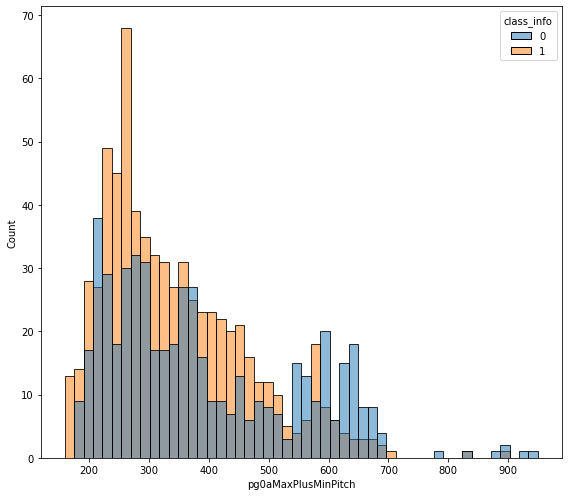

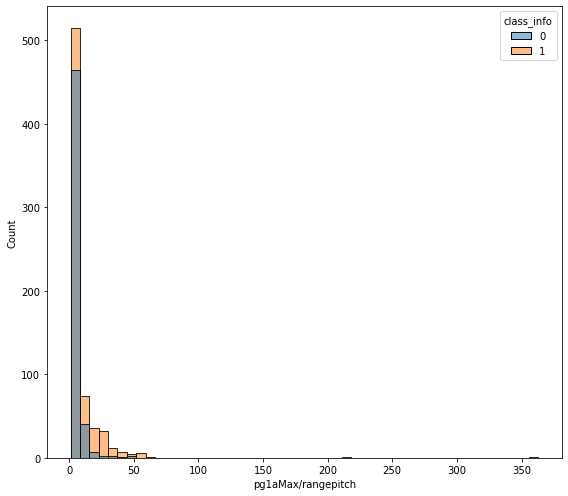

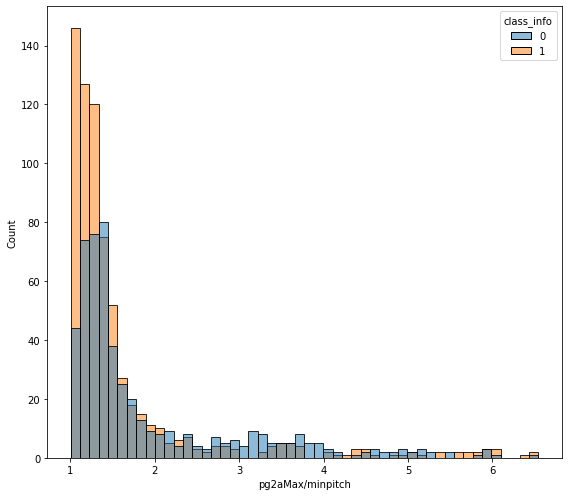

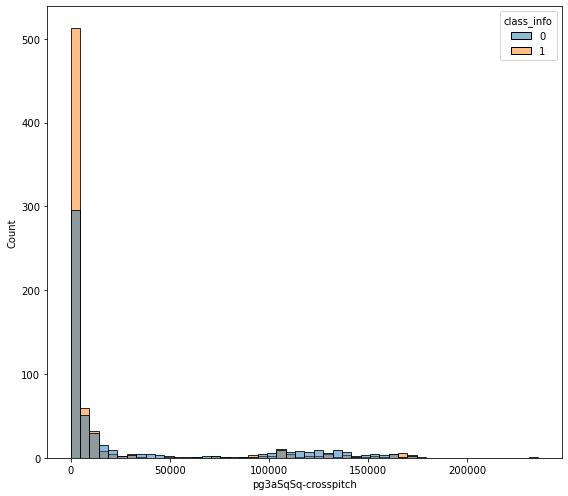

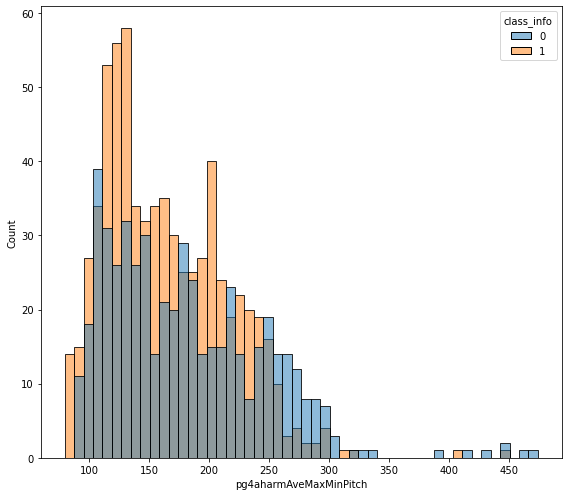

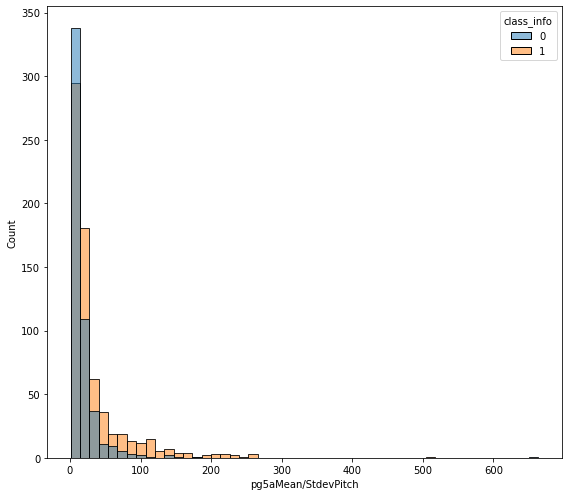

In [34]:
for col in gencols:
    plt.figure(figsize=(8, 7))
    #sns.distplot(train_df[col], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
    sns.histplot(train_df,x=col, bins=50, hue = 'class_info' )
    plt.ticklabel_format(style='plain')
    

    plt.tight_layout()

Visually as above, we can see there is some separation between classes for each feature; though the level of their predictive power remains to be tested.
So, depending on these threshold choices, we can make some adequate divisions of genders; we will leave it to the various models to see how useful these are for predicting PD.  
We could set thresholds, then cross validate to see if these threshold choices are any good, but really, the threshold choices are immaterial, the original engineered feature is more important.

# Monotonicity check  
One characteristic of PD is a monotone voice - we can make another pitch feature to check total pitch range.

In [35]:
train_df['pitchrange'] = train_df['max_pitch']-train_df['min_pitch']
train_df['pitchrange'].describe()

count    1208.000000
mean       89.419330
std       110.858429
min         0.754000
25%        22.911000
50%        44.010000
75%        91.779500
max       485.677000
Name: pitchrange, dtype: float64

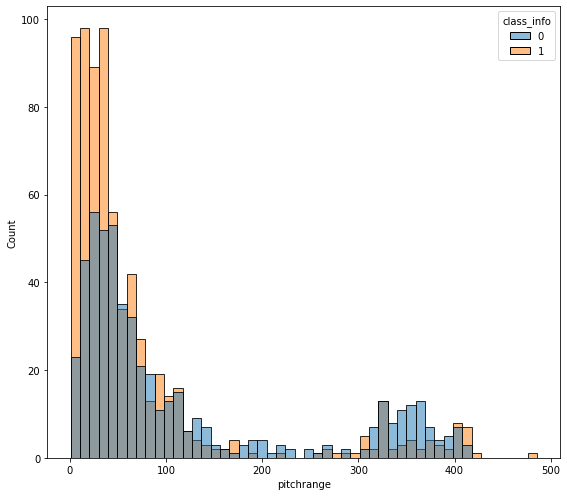

In [36]:
plt.figure(figsize=(8, 7))
#sns.distplot(train_df['pitchrange'], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
sns.histplot(train_df, x='pitchrange', bins=50, hue='class_info')
plt.ticklabel_format(style='plain')
plt.tight_layout()

#This looks to have some bimodality which we're looking for in this feature; though it seems to under-categorize the 
#higher range population.
#Lower range(i.e. higher monotonicity) is consistent with higher portion of PD patients.

# Oral Festination feature

As mentioned above:
"In Parkinson's disease (PD), festination corresponds to a tendency to speed up when performing repetitive movements. First described in gait (and then in handwriting and speech), festination is one of the most disabling axial symptoms" - https://pubmed.ncbi.nlm.nih.gov/17516477/

I attempt to describe oral festination using the existing features in the following way: the product of period_standard_deviation and jitter_ppq5.  


In [37]:
train_df['fest_pred'] = train_df['jitter_ppq5']*train_df['std_dev_of_period']
train_df['fest_pred'].describe()

count    1208.000000
mean        0.001177
std         0.001848
min         0.000002
25%         0.000179
50%         0.000587
75%         0.001375
max         0.017029
Name: fest_pred, dtype: float64

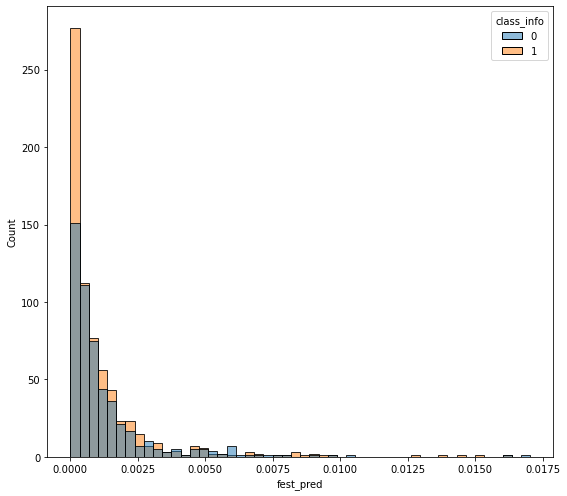

In [38]:
plt.figure(figsize=(8, 7))
#sns.distplot(train_df['fest_pred'], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
sns.histplot(train_df, x='fest_pred', bins=50, hue='class_info')
plt.ticklabel_format(style='plain')
plt.tight_layout()
#this doesn't appear to have great separation power at this point - though perhaps our models will be able to make more of it.

In [39]:
# make function for later use (uniformity on the test_df and pipelines)
def pred_eng_feat(df):
    '''creates the aforementioned engineered feature columns, given a dataframe'''
    df['pg0aMaxPlusMinPitch'] = df['max_pitch'] + df['min_pitch']
    #this potentially could be different than 2*mean, based on amount of time spent on those pitches

    df['pg1aMax/rangepitch'] = (df['max_pitch']/(df['max_pitch']-df['min_pitch']))

    df['pg2aMax/minpitch'] = ((df['max_pitch']/(df['min_pitch'])))

    df['pg3aSqSq-crosspitch'] = (df['max_pitch']**2 + df['min_pitch'] **2 -2*df['max_pitch']*df['min_pitch'])

    df['pg4aharmAveMaxMinPitch'] = ((df['max_pitch']*(df['min_pitch']))**(1/2) )

    df['pg5aMean/StdevPitch'] = df['mean_pitch']/df['std_dev']
    
    df['pitchrange'] = df['max_pitch']-df['min_pitch']
    
    df['fest_pred'] = df['jitter_ppq5']*df['std_dev_of_period']
    
    #train_df['pred_eng_feater0']O
    #gencols = ['pg0a', 'pg1a', 'pg2a', 'pg3a', 'pg4a']
    return df



# Train Test Split!

In [40]:
#Though I did consider making a Validation set, for the purposes of this investigation I don't think it adds value,
#also, I will be doing cross validation on the training set.
X = train_df.drop(['class_info', 'ID'], axis=1)
y = train_df['class_info']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=random_state_val)

### Now, including engineered features and train/test split, let's look at a correlation heatmap

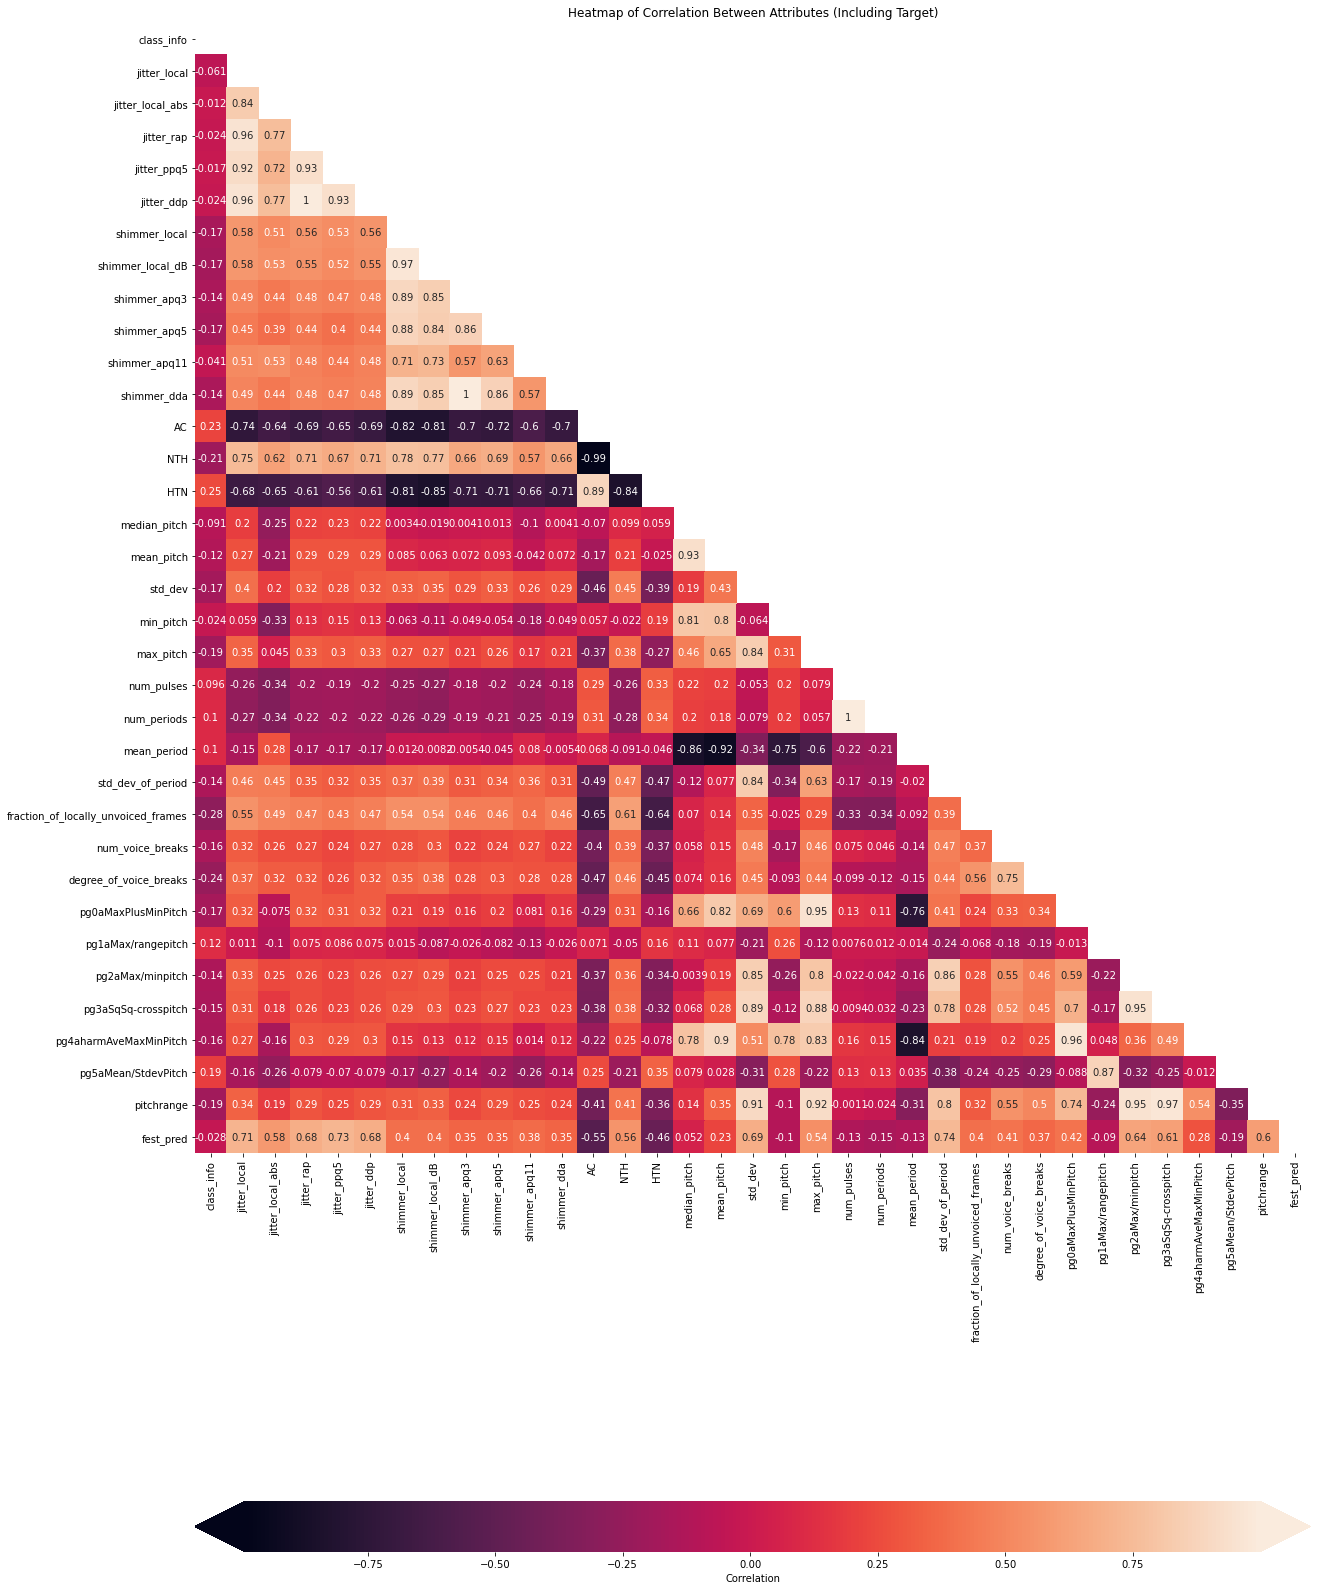

In [41]:
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

fig, ax = plt.subplots(figsize=(20, 32))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

So far, Class_info has correlation of highest magnitude with several Shimmer scores, AC, NTH, HTN, mean_pitch, std_dev(of pitch), max_pitch, fraction_of_locally_unvoiced_frames, num_voice_breaks, and degree_of_voice_breaks.  These all seem very descriptive with lowest "evenness" and consistency (and therefore control) of voice.    
There is also a noticeable amount of correlation between predictor variables.  In future analysis, it might be useful to perform PCA or another feature reduction process.  
Curiously, three of the projected gender columns as well as pitch_range also have good predictive potential. 

In [42]:
# checking in on number of predictors in X_train, to keep consistent with later
if verbose:
    print(len(X_train.columns))
    X_train.columns


# Defining a scaler  
Since many of our columns had very different ranges, let's uniformly scale the data.

In [43]:
#First, let's make some scaled X data, given we were noticing a wide discrepancy of ranges on those.
# Import StandardScaler
from sklearn.preprocessing import StandardScaler 

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
scaled_df_train.head()

,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_dB,shimmer_apq3,shimmer_apq5,shimmer_apq11,...,num_voice_breaks,degree_of_voice_breaks,pg0aMaxPlusMinPitch,pg1aMax/rangepitch,pg2aMax/minpitch,pg3aSqSq-crosspitch,pg4aharmAveMaxMinPitch,pg5aMean/StdevPitch,pitchrange,fest_pred
0,3.317641,4.230590,4.475005,3.694466,4.475276,0.967454,0.904302,1.021914,0.590161,0.378369,...,-0.008306,2.084230,-0.609549,-0.190772,-0.418276,-0.441948,-0.572814,-0.356222,-0.467181,1.959289
1,-0.509598,-0.173008,-0.573069,-0.488118,-0.572720,-0.175565,-0.006915,-0.623796,-0.291402,0.093226,...,0.618796,0.017600,-1.028099,-0.015315,-0.557788,-0.467983,-1.058557,-0.102243,-0.652394,-0.476209
2,-0.399138,-0.467621,-0.499729,-0.483799,-0.500069,0.642764,0.668061,0.952158,0.935140,0.064601,...,0.618796,0.509158,0.877074,-0.349023,0.709438,0.516657,0.829357,-0.539847,1.050460,-0.174553
3,-1.212877,-1.306819,-1.038934,-0.951986,-1.038577,-1.625436,-1.869425,-1.444336,-1.255912,-1.381751,...,-0.635407,-0.726088,0.870040,0.170187,-0.610403,-0.459403,1.219150,0.200669,-0.574189,-0.616697
4,0.409605,1.078662,0.279123,-0.197013,0.278770,0.781868,0.841023,0.113104,0.512356,0.565212,...,-0.008306,1.343551,-0.882736,-0.234968,-0.333644,-0.437504,-0.907784,-0.408583,-0.445000,-0.060814


# Some initial logistic regression exploration (and first foray into Pipeline)

In [44]:
#at the risk of overfitting, we can investigate the results if we OneHotEncode everything - yes, this is probably a bad idea
#because we have numerical data, not categorical.
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(categories='auto'),
    LogisticRegression(solver='lbfgs', multi_class='ovr',
                      max_iter=500))
pipe.fit(scaled_data_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, multi_class='ovr'))])

In [45]:
from sklearn.metrics import accuracy_score

# What's the accuracy of this prediction, measured against the training dataset?
y_pred = pipe.predict(scaled_data_train)
display(accuracy_score(y_train, y_pred))
#display()
score_suite(y_train, y_pred)

1.0

[['precision', 'recall', 'accuracy', 'f1_score', 'mcc'],
 [1.0, 1.0, 1.0, 1.0, 1.0]]

In [46]:
#Pipeline uses onehot encoding on EVERYTHING, so it misses some numerical values in the test set
# test_X = test_df.drop(['class_info', 'ID'], axis=1)
# len(test_X.columns)
# test_X.columns
# y_test_pred = pipe.predict(test_X)
# accuracy_score(test_df['class_info'], y_test_pred)

This is great results on the training set, but certainly overfit.  If we try to run this process on the test set through, we miss values (because we had numerical data, not categorical!)  


Instead, let's use a logistic regression without onehotencoding.

In [47]:
logreg = LogisticRegression(solver='lbfgs', multi_class='ovr',
                      max_iter=500, random_state=random_state_val)
logreg.fit(scaled_data_train, y_train)
y_pred = logreg.predict(scaled_data_train)
print("Initial report:")
print("Training scores:")
display('accuracy:',accuracy_score(y_train, y_pred))
display(score_suite(y_train, y_pred))
print("Test scores:")
y_test_pred = logreg.predict(scaled_data_test)
display(score_suite(y_test, y_test_pred))



Initial report:
Training scores:


'accuracy:'

0.6942604856512141

[['precision', 'recall', 'accuracy', 'f1_score', 'mcc'],
 [0.7036395147313691,
  0.79296875,
  0.6942604856512141,
  0.7456382001836547,
  0.37003397053203063]]

Test scores:


[['precision', 'recall', 'accuracy', 'f1_score', 'mcc'],
 [0.6855670103092784,
  0.7556818181818182,
  0.6556291390728477,
  0.718918918918919,
  0.27937426763822565]]

In [48]:
# report(y_pred,y_train, 'Train')#switched order for testing
# report(y_test_pred,y_test, 'Test')#switched order for testing

In [49]:
print("Note, the recall line for output 1 (i.e. second line) is the desired metric to take, and the accuracy number under f1-score")
report(y_train, y_pred, 'Train')
report(y_test, y_test_pred, 'Test')

Note, the recall line for output 1 (i.e. second line) is the desired metric to take, and the accuracy number under f1-score
----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       394
           1       0.70      0.79      0.75       512

    accuracy                           0.69       906
   macro avg       0.69      0.68      0.68       906
weighted avg       0.69      0.69      0.69       906

--Confusion Matrix:
[[0.24613687 0.18874172]
 [0.11699779 0.44812362]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       126
           1       0.69      0.76      0.72       176

    accuracy                           0.66       302
   macro avg       0.64      0.64      0.64       302
weighted avg       0.65      0.66      0.65       302

--C

This recall of 79.2% on the training set is not bad; it falls to 76% on the test set.  
Accuracy is 69% on train and 66% on test.
On cross validation (see below) we run about 67% accuracy on average.

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
score = np.mean(cross_val_score(logreg, scaled_data_train, y_train, cv=cv_def, scoring=scoring_p))#'neg_mean_squared_error'))#scoring='neg_mean_squared_error' / 'r2'
display(score)
logregmeanscore = score
logregscore = cross_val_score(logreg, X_train, y_train, cv=cv_def, scoring=scoring_p)
logregscore

0.6688604213466092

array([0.68131868, 0.6519337 , 0.62983425, 0.66298343, 0.73480663])

Let's look at feature importances on the logistic regression

In [51]:
sorted(zip(logreg.coef_[0], X_train.columns))

[(-0.549147275631258, 'pitchrange'),
 (-0.5163790032278385, 'pg4aharmAveMaxMinPitch'),
 (-0.37595019447210826, 'fraction_of_locally_unvoiced_frames'),
 (-0.3640481850819683, 'mean_period'),
 (-0.3396152831775756, 'max_pitch'),
 (-0.2648689054475498, 'num_pulses'),
 (-0.2457911422001787, 'pg1aMax/rangepitch'),
 (-0.2001022042215298, 'mean_pitch'),
 (-0.17249172728720874, 'std_dev_of_period'),
 (-0.14504417061662453, 'degree_of_voice_breaks'),
 (-0.13175775337867524, 'shimmer_apq5'),
 (-0.12977235910273086, 'pg0aMaxPlusMinPitch'),
 (-0.05954418113044324, 'jitter_ppq5'),
 (-0.04404228544760391, 'median_pitch'),
 (-0.03142896598418587, 'shimmer_dda'),
 (-0.03009309096692092, 'shimmer_apq3'),
 (0.020883616404521944, 'num_voice_breaks'),
 (0.09025945142330018, 'shimmer_local'),
 (0.10961962102007389, 'jitter_ddp'),
 (0.1099587100067312, 'jitter_rap'),
 (0.11787846795302934, 'NTH'),
 (0.18229827539629054, 'std_dev'),
 (0.1952261759426981, 'fest_pred'),
 (0.21259142173469117, 'jitter_local'),


Degree of voice breaks and fraction of locally unvoiced frames here seems very surprising to have inverse correlation with PD.  There are outliers here that likely skew the data, especially since most of the degree_of_voice_breaks values are near 0.  
Optimistically, we will find a model that drops out certain features that fits better.  

HTN and Shimmer_apq11 are again one of the stronger predictors, but we also see jitter_local_abs, AC, and our engineered features pg3, pg5 and fest_pred appearing.

# K-Nearest Neighbors  
Let's try a KNN model, and investigate it manually (NB: technically we are using the train/test split's test set here to optimize a hyperparameter k - which is not ideal - so we we wouldn't employ this technique for validation, just in this case for gaining perspective).
Once we've taken a look at that, let's use GridSearchCV.

Now we can proceed with KNN investigation using both scaled and non-scaled data.

In [221]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#kn

##fit KNN model
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier()

# Fit the classifier
clf.fit(scaled_data_train, y_train)
print('params:', clf.get_params())

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    print("MCC Score: {}".format(mcc(labels, preds)))
    
print("---Metrics for Initial KNN on test set (No CV or param search)---")
print_metrics(y_test, test_preds)

#labels = y_train#train_df['class_info']
#train_df['class_info'].value_counts()

##improve model perf - search for better k

def find_best_k(X_train, y_train, X_test, y_test, scoremetric, min_k=1, max_k=25):
    '''iterates through kvalues, trains on train set, returns optimal k value for test set
    WARNING - this technique uses the test set in order to find and optimize the hyperparameter k.  '''
    best_k = 0
    best_score = 0.0
    if min_k % 2==0:
        min_k+=1
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_train)
        newscore = eval(scoremetric+'(y_train, preds)')
        if newscore > best_score:
            best_k = k
            best_score = newscore
            best_knn_params = knn.get_params()
    print("\n---Metrics for Parameter-searched KNN, without CrossValidation---")
    print('(using {} as optimization metric)'.format(scoremetric))
    print("Best Value for k: {}".format(best_k))
    #print("{}-Score: {}".format(scoremetric, best_score))
    test_preds = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train).predict(X_test)
    train_preds = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train).predict(X_train)
    print("\nTrain set metrics:")
    print_metrics(y_train, train_preds)
    print("\nTest set metrics:")
    print_metrics(y_test, test_preds)

    report(y_train, train_preds, 'Train')
    report(y_test, test_preds, 'Test')
    
    print('Best Knn Params:', best_knn_params)
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test, scoring_p)



params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
---Metrics for Initial KNN on test set (No CV or param search)---
Precision Score: 0.7379679144385026
Recall Score: 0.7840909090909091
Accuracy Score: 0.7119205298013245
F1 Score: 0.7603305785123966
MCC Score: 0.40132021753008656

---Metrics for Parameter-searched KNN, without CrossValidation---
(using accuracy as optimization metric)
Best Value for k: 1

Train set metrics:
Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0
MCC Score: 1.0

Test set metrics:
Precision Score: 0.735632183908046
Recall Score: 0.7272727272727273
Accuracy Score: 0.6887417218543046
F1 Score: 0.7314285714285715
MCC Score: 0.3614119300808844
----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00  

So, with just the original train/test split, with no crossvalidation, optimizing the k-value gives a k-value of 3 and test set recall of 73% and accuracy 69%.   
However, we can increase reliability by employing GridSearchCV to optimize k-values.


### Let's try this using GridSearchCV, both using scaled data and unscaled, just to see impact of that

In [223]:
k_range = list(range(1,25))
knn_param_grid = dict(n_neighbors=k_range, metric=['minkowski', 'hamming'],
                     algorithm=['auto'], leaf_size=[30], metric_params=[None], n_jobs=[None],
                     p=[2], weights=['uniform'])
#scoring_p='recall' #or None

In [224]:
def grid_search_knn(clf, X_train, y_train, X_test, y_test, label):
    '''flexibly run knn gridsearch using different train/test sets'''
    cv = cv_def
    knn_grid_search = GridSearchCV(clf, knn_param_grid, cv=cv, return_train_score=True, scoring = scoring_p)

    knn_grid_search.fit(X_train, y_train)
    ##examine best params
    # Mean training score
    #knn_gs_training_score = np.mean(knn_grid_search.score(X_train, y_train))
    knn_gs_training_score = np.mean(knn_grid_search.cv_results_['mean_train_score'])
    verboseLocal=False
    if verboseLocal:
        print('GridSearch cv scores:')
        print (knn_grid_search.cv_results_['mean_train_score'])
    # Mean test score
    knn_gs_testing_score = np.mean(knn_grid_search.score(X_test, y_test))
    
    #Max scores
    ##knn_train_max = np.max(knn_grid_search.cv_results_['mean_train_score'])
    ##knn_test_max = np.max(knn_grid_search.score(X_test, y_test))

    print("--Using {} Data--".format(label))
    print('Scoring type KNN: {}'.format(scoring_p))
    if verbose:
        print(f"CV results: {knn_grid_search.cv_results_['mean_train_score']}")
        print(f"Mean CV Training Score KNN: {knn_gs_training_score :.2%}")
    print(f"Mean Test Score KNN: {knn_gs_testing_score :.2%}")
    #print(f"Max Training Score KNN: {knn_train_max :.2%}")
    #print(f"Max Test Score KNN: {knn_test_max :.2%}")
    ##This best_score line is really the mean score for the best estimator - not sure if really that illuminating
    #print(f"Best Score for KNN(training set): {knn_grid_search.best_score_ :.2%}")
    print("Optimal Parameters for KNN Grid Search (Training):", knn_grid_search.best_params_)
    print()
    return knn_grid_search, knn_gs_training_score

In [225]:

#KNN Using Gridsearch - unscaled data
clf = KNeighborsClassifier()
gsknn_us, knngs_u_trainscore =grid_search_knn(clf, X_train, y_train, X_test, y_test, 'Unscaled')


--Using Unscaled Data--
Scoring type KNN: accuracy
Mean Test Score KNN: 61.92%
Optimal Parameters for KNN Grid Search (Training): {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}



In [226]:

#KNN Using Gridsearch - scaled data
clf = KNeighborsClassifier()
gsknn_s, knngs_s_trainscore=grid_search_knn(clf, scaled_data_train, y_train, scaled_data_test, y_test, 'Scaled')


--Using Scaled Data--
Scoring type KNN: accuracy
Mean Test Score KNN: 70.20%
Optimal Parameters for KNN Grid Search (Training): {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}



In [227]:
#best knn - using scaled data for final version since in general experience indicates it should do better across all models, for consistency.
knnbp = gsknn_s.best_params_
met, n_n = knnbp['metric'], knnbp['n_neighbors']
best_knn = KNeighborsClassifier(n_neighbors=n_n, metric=met)
best_knn.fit(scaled_data_train, y_train)
print("Scaled Data Scores")
print('Train accuracy:', best_knn.score(scaled_data_train, y_train))
print('Test accuracy:', best_knn.score(scaled_data_test, y_test))

Scaled Data Scores
Train accuracy: 0.7836644591611479
Test accuracy: 0.7019867549668874


In [228]:
report(y_train, best_knn.predict(scaled_data_train), 'Train')
report(y_test, best_knn.predict(scaled_data_test), 'Test')

----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       394
           1       0.83      0.78      0.80       512

    accuracy                           0.78       906
   macro avg       0.78      0.78      0.78       906
weighted avg       0.79      0.78      0.78       906

--Confusion Matrix:
[[0.34216336 0.09271523]
 [0.12362031 0.4415011 ]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       126
           1       0.75      0.73      0.74       176

    accuracy                           0.70       302
   macro avg       0.69      0.70      0.69       302
weighted avg       0.70      0.70      0.70       302

--Confusion Matrix:
[[0.27483444 0.14238411]
 [0.15562914 0.42715232]]
------------------------------------------


I'll proceed with scaled data since experience indicates it should do better.

## Knn discussion
Knn does pretty well - 70% accuracy on test set, with 73% recall.

In [59]:
X_train
#y_test
#remove this

,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_dB,shimmer_apq3,shimmer_apq5,shimmer_apq11,...,num_voice_breaks,degree_of_voice_breaks,pg0aMaxPlusMinPitch,pg1aMax/rangepitch,pg2aMax/minpitch,pg3aSqSq-crosspitch,pg4aharmAveMaxMinPitch,pg5aMean/StdevPitch,pitchrange,fest_pred
660,8.343,0.000614,5.433,5.478,16.300,17.362,1.514,8.309,9.826,13.266136,...,1.0,42.044,277.896,4.172764,1.315183,1431.260224,137.654392,10.793245,37.832,0.004903
617,1.448,0.000132,0.546,0.636,1.639,10.698,1.082,3.331,5.883,11.493000,...,2.0,11.126,219.408,6.953936,1.167956,288.932004,109.374287,21.906935,16.998,0.000278
853,1.647,0.000099,0.617,0.641,1.850,15.469,1.402,8.098,11.369,11.315000,...,2.0,18.480,485.636,1.664338,2.505258,43491.434116,219.289130,2.758144,208.546,0.000851
87,0.181,0.000007,0.095,0.099,0.286,2.245,0.199,0.849,1.569,2.321000,...,0.0,0.000,484.653,9.894321,1.112431,665.382025,241.983031,35.161850,25.795,0.000012
687,3.104,0.000269,1.371,0.973,4.112,16.280,1.484,5.560,9.478,14.428000,...,1.0,30.963,239.721,3.472215,1.404496,1626.266929,118.152328,8.502037,40.327,0.001067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,1.306,0.000070,0.491,0.565,1.472,7.261,0.794,1.815,2.702,5.420000,...,1.0,25.941,366.285,2.811909,1.551904,6275.333089,178.808115,10.234487,79.217,0.000308
211,2.425,0.000215,1.178,1.214,3.534,11.826,1.113,4.656,6.290,10.600000,...,0.0,0.000,232.859,7.569616,1.152216,271.227961,116.137942,36.386415,16.469,0.000562
502,2.188,0.000110,1.047,1.385,3.142,13.608,1.361,6.250,8.799,14.874000,...,1.0,24.219,400.930,3.501153,1.399816,4461.705616,197.663324,8.571051,66.796,0.000911
537,3.575,0.000336,1.264,1.124,3.793,10.458,0.831,6.216,8.278,12.083200,...,0.0,0.000,212.338,10.108054,1.109793,122.102500,106.025143,24.467263,11.050,0.000942


In [60]:
len(scaled_data_train)
scaled_data_train
#remove this

array([[ 3.31764105,  4.23059001,  4.47500503, ..., -0.35622201,
        -0.46718062,  1.95928913],
       [-0.50959802, -0.17300767, -0.57306914, ..., -0.1022431 ,
        -0.65239407, -0.47620896],
       [-0.39913819, -0.46762069, -0.49972899, ..., -0.53984657,
         1.0504602 , -0.17455319],
       ...,
       [-0.09884285, -0.37065078, -0.05555631, ..., -0.40700537,
        -0.20969179, -0.14300796],
       [ 0.67104556,  1.69222414,  0.16859595, ..., -0.04373243,
        -0.70527156, -0.12644833],
       [ 0.07434041,  0.46839295, -0.14852269, ..., -0.33342526,
        -0.41272072, -0.17574175]])

## Now, let's try Decision Trees and Random Forests  
We ran a simple decision tree at the beginning to get a sense of basic feature importances.  Now we can search through a grid of some other parameters

In [61]:
# decision trees! 
# and random forests!

if verbose:
    verb = 4
else:
    verb = 0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=random_state_val)
#scoring_p='recall' #or None
cv = cv_def
dt_cv_score = cross_val_score(dt_clf, scaled_data_train, y_train, cv=cv, scoring = scoring_p)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score for basic (non-grid-searched) DT: {mean_dt_cv_score :.2%}")
##grid search decision trees
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4,],
    'min_samples_split': [10, 20, 40],

}

##number of trees
num_decision_trees = np.prod([len(l) for l in dt_param_grid.values()]) * (5 if cv==None else cv_def)
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=cv, return_train_score=True, scoring = scoring_p, verbose=verb)

##################begin repaste!!!
# dt_clf = DecisionTreeClassifier(random_state=random_state_val)
# scoring_p='recall' #or None
# dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=cv_def, scoring = scoring_p)
# mean_dt_cv_score = np.mean(dt_cv_score)

# print(f"Mean Cross Validation Score for DT: {mean_dt_cv_score :.2%}")

# dt_clf.fit(X_train, y_train)
# y_preds = dt_clf.predict(X_train)
# print("Fitted Score for DT training set: ", recall(y_preds, y_train))
# y_test_preds = dt_clf.predict(X_test)
# print("Recall Score for DT test set: ", recall(y_test_preds, y_test))


# #print(dt_clf.get_params())
# #print(dt_clf.feature_importances_)

# plot_feature_importances(dt_clf)
###################end repaste
# Fit to the data
dt_grid_search.fit(scaled_data_train, y_train)#scaled_data_train, y_train, scaled_data_test, y_test
##examine best params
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = np.mean(dt_grid_search.score(scaled_data_test, y_test))

print('Scoring type DT: {}'.format(scoring_p ))
print(f"Mean Training Score DT: {dt_gs_training_score :.2%}")
#print(f"Mean Test Score DT: {dt_gs_testing_score :.2%}")
#print(f"Best Score for Decision Trees(training set): {dt_grid_search.best_score_ :.2%}")
print("Optimal Parameters for Decision Tree Grid Search (Training):", dt_grid_search.best_params_)
print()



Mean Cross Validation Score for basic (non-grid-searched) DT: 64.03%
Grid Search will have to search through 270 different permutations.
Scoring type DT: accuracy
Mean Training Score DT: 68.90%
Optimal Parameters for Decision Tree Grid Search (Training): {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10}



In [62]:
dtbp = dt_grid_search.best_params_
c, md, msl, mss = dtbp['criterion'], dtbp['max_depth'], dtbp['min_samples_leaf'], dtbp['min_samples_split']
best_dt = DecisionTreeClassifier(criterion=c,
    max_depth=md,
    min_samples_split=mss,
    min_samples_leaf=msl,
    random_state=random_state_val)
best_dt.fit(scaled_data_train, y_train)
# print(best_dt.score(scaled_data_train, y_train))
# print(best_dt.score(scaled_data_test, y_test))
##print(dt_grid_search.cv_results_)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=10,
                       random_state=7)

In [63]:
report(y_train, best_dt.predict(scaled_data_train), 'Train')
report(y_test, best_dt.predict(scaled_data_test), 'Test')

----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.84      0.38      0.52       394
           1       0.66      0.94      0.78       512

    accuracy                           0.70       906
   macro avg       0.75      0.66      0.65       906
weighted avg       0.74      0.70      0.67       906

--Confusion Matrix:
[[0.16335541 0.27152318]
 [0.03200883 0.53311258]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.63      0.27      0.38       126
           1       0.63      0.89      0.74       176

    accuracy                           0.63       302
   macro avg       0.63      0.58      0.56       302
weighted avg       0.63      0.63      0.59       302

--Confusion Matrix:
[[0.11258278 0.30463576]
 [0.06622517 0.51655629]]
------------------------------------------


In [64]:
#Just checking that the grid_searched result matches the best_dt model result - it does.
report(y_train, dt_grid_search.predict(scaled_data_train), 'Train')
report(y_test, dt_grid_search.predict(scaled_data_test), 'Test')

----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.84      0.38      0.52       394
           1       0.66      0.94      0.78       512

    accuracy                           0.70       906
   macro avg       0.75      0.66      0.65       906
weighted avg       0.74      0.70      0.67       906

--Confusion Matrix:
[[0.16335541 0.27152318]
 [0.03200883 0.53311258]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.63      0.27      0.38       126
           1       0.63      0.89      0.74       176

    accuracy                           0.63       302
   macro avg       0.63      0.58      0.56       302
weighted avg       0.63      0.63      0.59       302

--Confusion Matrix:
[[0.11258278 0.30463576]
 [0.06622517 0.51655629]]
------------------------------------------


Not bad metrics here for decision trees - 89% recall on test set, and 63% accuracy on test set.

## Random Forest

In [65]:
#check out maximum number of predictors
len(X_train.columns)

34

In [66]:

###########################################
##Random Forest model
cv_rf = cv_def #20
rf_clf = RandomForestClassifier(random_state=random_state_val)
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, scaled_data_train, y_train, cv=cv_rf, scoring = scoring_p))

print(f"Mean Cross Validation Score for default (non-gridsearched) Random Forest Classifier: {mean_rf_cv_score :.2%}")

rf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6],
    'min_samples_leaf': [0, 1, 3],
    'min_samples_split': [0,  2, 5, 10],
    'n_estimators': [2, 10, 30, 34],
}
print('Now, using GridSearchCV,')
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=cv_rf, return_train_score=True, scoring = scoring_p, verbose=verb)
rf_grid_search.fit(scaled_data_train, y_train)

# Mean training score
#rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])
rf_gs_training_score = np.mean(rf_grid_search.score(scaled_data_train, y_train))

# Mean test score
rf_gs_testing_score = np.mean(rf_grid_search.score(scaled_data_test, y_test))

print("")

print('Scoring type RF: {}'.format(scoring_p ))
print(f"Mean Training Score RF: {rf_gs_training_score :.2%}")
print(f"Mean Test Score RF: {rf_gs_testing_score :.2%}")


#print(f"Best Score for Random Forest(training set): {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters for Random Forest Grid Search(Training): {rf_grid_search.best_params_}")

Mean Cross Validation Score for default (non-gridsearched) Random Forest Classifier: 71.52%
Now, using GridSearchCV,

Scoring type RF: accuracy
Mean Training Score RF: 84.33%
Mean Test Score RF: 65.56%

Optimal Parameters for Random Forest Grid Search(Training): {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 10}


In [67]:
#rf_grid_search.get_params()
report(y_train, rf_grid_search.predict(scaled_data_train), 'Train')
report(y_test, rf_grid_search.predict(scaled_data_test), 'Test')

----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       394
           1       0.84      0.89      0.87       512

    accuracy                           0.84       906
   macro avg       0.84      0.84      0.84       906
weighted avg       0.84      0.84      0.84       906

--Confusion Matrix:
[[0.3388521  0.09602649]
 [0.0607064  0.50441501]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       126
           1       0.69      0.75      0.72       176

    accuracy                           0.66       302
   macro avg       0.64      0.64      0.64       302
weighted avg       0.65      0.66      0.65       302

--Confusion Matrix:
[[0.21854305 0.1986755 ]
 [0.14569536 0.43708609]]
------------------------------------------


In [68]:

# ##check performance on test set  - was used in prior version for investigation
# dt_scoretrain = dt_grid_search.score(scaled_data_train, y_train)
# rf_scoretrain = rf_grid_search.score(scaled_data_train, y_train)

# dt_score = dt_grid_search.score(scaled_data_test, y_test)
# rf_score = rf_grid_search.score(scaled_data_test, y_test)

# print()
# print('Decision tree grid search score-Train Set: ', dt_scoretrain)
# print('Random forest grid search score-Train Set: ', rf_scoretrain)


# print('Decision tree grid search score-Test Set: ', dt_score)
# print('Random forest grid search score-Test Set: ', rf_score)


Using GridSearch on Decision Trees, we're able to get about 89% recall and 63% accuracy on the test set.
For random forests, we get about 75% recall and 66% accuracy on the test set.
We typically presume RF outperforms DT, but in a stable situation, the DT can do as well as the RF; and if the RF doesn't actually arrive at the optimal tree, a single lucky DT can even do better - though of course we must be wary of this lucky DT for overfitting.  In this case, the DT overfits for recall on class 1, at the expense of doing poorly on class 0.
Furthermore, the DT had higher recall also at the cost of precision - namely, it could This informs our choice of metric.
Still, both are impressive.

### For the found optimal parameters, let's take a look at the feature importances.

Decision Tree Feature Importances
Random Forest Feature Importances


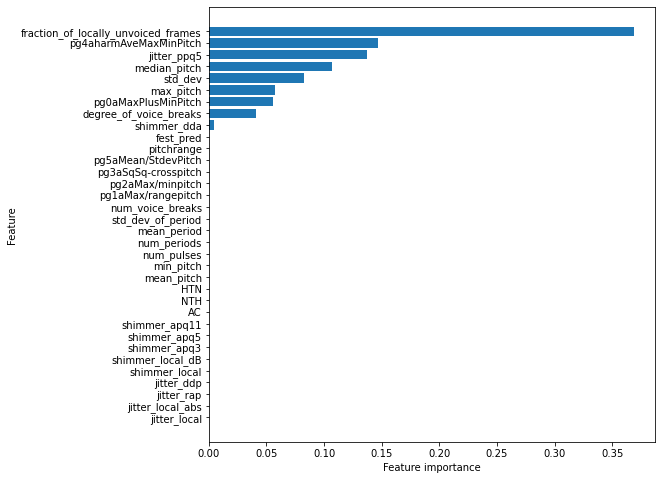

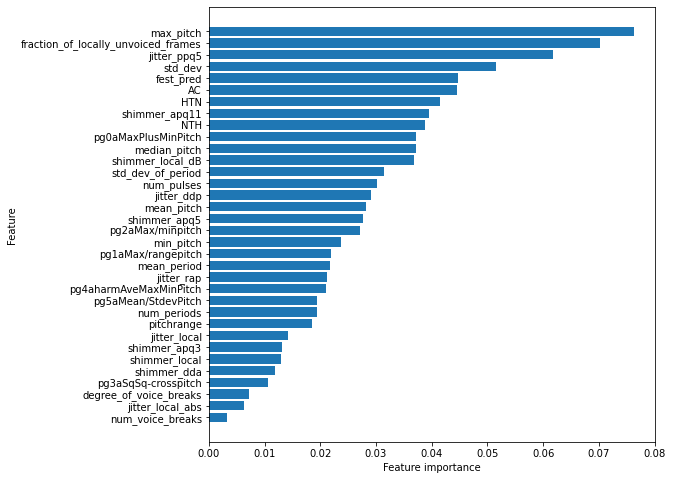

In [69]:
dtbp =  dt_grid_search.best_params_
rfbp = rf_grid_search.best_params_

c, md, msl, mss = dtbp['criterion'], dtbp['max_depth'], dtbp['min_samples_leaf'], dtbp['min_samples_split']
c2, md2, msl2, mss2, ne2 = rfbp['criterion'], rfbp['max_depth'], rfbp['min_samples_leaf'], rfbp['min_samples_split'], rfbp['n_estimators']

# # c, md, msl, mss = 'entropy', None, 6, 10
# # c2, md2, msl2, mss2, ne2 = 'gini', 6, 6, 10, 100

best_dt = DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl, 
                                 min_samples_split=mss, random_state=random_state_val).fit(scaled_data_train, y_train)
print("Decision Tree Feature Importances")
plot_feature_importances(best_dt)

best_rf = RandomForestClassifier(criterion=c2, max_depth=md2, min_samples_leaf=msl2, 
                                 min_samples_split=mss2, n_estimators=ne2, random_state=random_state_val).fit(scaled_data_train, y_train)
print("Random Forest Feature Importances")
plot_feature_importances(best_rf)

In [70]:
dtfi = zip_feature_importances(best_dt, pd.DataFrame(scaled_df_train))
rffi = zip_feature_importances(best_rf, pd.DataFrame(scaled_df_train))
display('decision tree features:', dtfi)
display('random forest features:', rffi)

'decision tree features:'

[(0.0, 'jitter_local'),
 (0.0, 'jitter_local_abs'),
 (0.0, 'jitter_rap'),
 (0.0, 'jitter_ddp'),
 (0.0, 'shimmer_local'),
 (0.0, 'shimmer_local_dB'),
 (0.0, 'shimmer_apq3'),
 (0.0, 'shimmer_apq5'),
 (0.0, 'shimmer_apq11'),
 (0.0, 'AC'),
 (0.0, 'NTH'),
 (0.0, 'HTN'),
 (0.0, 'mean_pitch'),
 (0.0, 'min_pitch'),
 (0.0, 'num_pulses'),
 (0.0, 'num_periods'),
 (0.0, 'mean_period'),
 (0.0, 'std_dev_of_period'),
 (0.0, 'num_voice_breaks'),
 (0.0, 'pg1aMax/rangepitch'),
 (0.0, 'pg2aMax/minpitch'),
 (0.0, 'pg3aSqSq-crosspitch'),
 (0.0, 'pg5aMean/StdevPitch'),
 (0.0, 'pitchrange'),
 (0.0, 'fest_pred'),
 (0.00472546341185794, 'shimmer_dda'),
 (0.04067841455283559, 'degree_of_voice_breaks'),
 (0.055353130464763034, 'pg0aMaxPlusMinPitch'),
 (0.05768777144559786, 'max_pitch'),
 (0.08244372058679424, 'std_dev'),
 (0.10689796340233707, 'median_pitch'),
 (0.13704285385106438, 'jitter_ppq5'),
 (0.14640048552555399, 'pg4aharmAveMaxMinPitch'),
 (0.36877019675919587, 'fraction_of_locally_unvoiced_frames')]

'random forest features:'

[(0.003231578990594731, 'num_voice_breaks'),
 (0.0063961373093827404, 'jitter_local_abs'),
 (0.007224846998730587, 'degree_of_voice_breaks'),
 (0.010627129331572319, 'pg3aSqSq-crosspitch'),
 (0.011837145475296268, 'shimmer_dda'),
 (0.012877495301703828, 'shimmer_local'),
 (0.013180206456678462, 'shimmer_apq3'),
 (0.014165079181057052, 'jitter_local'),
 (0.018518884382748405, 'pitchrange'),
 (0.01934644023055519, 'num_periods'),
 (0.01939262120322518, 'pg5aMean/StdevPitch'),
 (0.021018323473935504, 'pg4aharmAveMaxMinPitch'),
 (0.021153726548508188, 'jitter_rap'),
 (0.021665961323275824, 'mean_period'),
 (0.02199437669439311, 'pg1aMax/rangepitch'),
 (0.023627889900626132, 'min_pitch'),
 (0.027056242751586624, 'pg2aMax/minpitch'),
 (0.02767378788999546, 'shimmer_apq5'),
 (0.02811526744996784, 'mean_pitch'),
 (0.029115724457363146, 'jitter_ddp'),
 (0.030239891471865576, 'num_pulses'),
 (0.03151208541475186, 'std_dev_of_period'),
 (0.03680883665849419, 'shimmer_local_dB'),
 (0.0372174122099

This is pretty good.
Two of our engineered predictors play a role in the decision tree, and they do make a respectable appearance in the random forest importances.

# Bagging (Bootstrap Aggregation)  
In short, Random Forests are a customized version of bagging, so RF should outperform bagging.  Nevertheless, let's take a look.  
After all, DT did surprisingly well compared to RF, too.

Results for a few different estimator counts, on our training set (mean scores over crossval)
>NumberEstimators: 10 Metric (accuracy) :0.659 StDev:(0.032)
  >Max score: 0.702 Min score:0.626 
>NumberEstimators: 50 Metric (accuracy) :0.703 StDev:(0.018)
  >Max score: 0.728 Min score:0.685 
>NumberEstimators: 100 Metric (accuracy) :0.701 StDev:(0.020)
  >Max score: 0.725 Min score:0.675 
>NumberEstimators: 500 Metric (accuracy) :0.715 StDev:(0.026)
  >Max score: 0.752 Min score:0.692 
>NumberEstimators: 1000 Metric (accuracy) :0.720 StDev:(0.034)
  >Max score: 0.765 Min score:0.682 


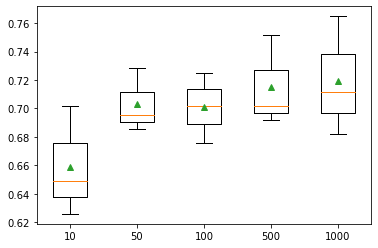

Best average score over cross validation: 0.7196467991169978
Best model: 1000


In [71]:
#!!! continue here
# bootstrap aggregation aka bagging
##refer also to this: https://machinelearningmastery.com/bagging-ensemble-with-python/

#Manual parameter search through bagging

####

#from numpy import mean
import pandas as pd
import numpy as np
#np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold

# cv=3
# #For more specificity in the CV, use this...
# #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state_val)

# #n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# bag_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=cv, scoring = scoring_p)

# get a list of models to evaluate
best_score_bag = 0
best_bag = None
def get_models():
    '''create a battery of bagging models with different estimators'''
    dtmodels = dict()
    #rfmodels = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000]#, 5000, 10000]# time constraints make 5000+ more difficult
    for n in n_trees:
        dtmodels[str(n)] = BaggingClassifier(n_estimators=n, random_state=random_state_val)
        #rfmodels[str(n)] = BaggingClassifier(n_estimators=n) 
    return dtmodels #, rfmodels

def evaluate_model(model, X, y, scoring_p):
    '''evaluate mean crossvalidation scores for a model, test set, scoring system'''
    # define evaluation procedure
    ##cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=random_state_val)
    ##replace cv with this customized version if necessary
    cv = 3
    # evaluate the model 
    #model.fit(X, y)
    scores = cross_val_score(model, X, y, scoring=scoring_p, cv=cv)
    return scores

models = get_models()
results, names = list(), list()
scoring_bag = scoring_p
print('Results for a few different estimator counts, on our training set (mean scores over crossval)')
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, scaled_data_train, y_train, scoring_bag)
    if np.mean(scores)>best_score_bag:
        best_score_bag = np.mean(scores)
        best_bag = model
        best_bag_name = name
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>NumberEstimators: %s Metric (%s) :%.3f StDev:(%.3f)' % (name, scoring_p, np.mean(scores), np.std(scores)))
    print('  >Max score: %.3f Min score:%.3f ' % (np.max(scores), np.min(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

print("Best average score over cross validation: {}".format(best_score_bag))
print("Best model: {}".format(best_bag_name))

In [82]:
#here, since there isn't significant gain between 50 and 1000, we can use 50
best_bag = BaggingClassifier(n_estimators=50).fit(scaled_data_train, y_train)


In [83]:
report(y_train, best_bag.predict(scaled_data_train), 'Train')
report(y_test, best_bag.predict(scaled_data_test), 'Test')

----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       512

    accuracy                           1.00       906
   macro avg       1.00      1.00      1.00       906
weighted avg       1.00      1.00      1.00       906

--Confusion Matrix:
[[0.43487859 0.        ]
 [0.         0.56512141]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       126
           1       0.72      0.76      0.74       176

    accuracy                           0.69       302
   macro avg       0.68      0.68      0.68       302
weighted avg       0.69      0.69      0.69       302

--Confusion Matrix:
[[0.24834437 0.16887417]
 [0.13907285 0.44370861]]
------------------------------------------


Using Bagging, we have good results in a short time; with 50 estimators, we get a CV score of 70% accuracy on the training set.  
This corresponds to a test set accuracy of 69%.

# ADABoost & Gradient Boosting  
These techniques use ensembles of weak learners, each new weak learner crafted to remedy specific miscategorization(s) of previous ones, then put together into an ensemble which does very well at fitting every point.  Outliers have big impact on these models, though overfitting is experimentally less of a problem than expected.  

In [84]:
def display_scores(actual, preds, model_name):
    acc = accuracy_score(actual, preds)
    f1 = f1_score(actual, preds)
    rec = recall_score(actual, preds)
    print("Model: {}".format(model_name))
    if verbose:
        print("Accuracy: {}".format(acc))
    print("Recall: {}".format(rec))
    if verbose:
        print("F1-Score: {}".format(f1))

In [85]:
#ADA & gradient boosting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score

adaboost_clf = AdaBoostClassifier(random_state=random_state_val)

# Fit AdaBoostClassifier
adaboost_clf.fit(scaled_data_train, y_train)

# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(scaled_data_train)
adaboost_test_preds = adaboost_clf.predict(scaled_data_test)

In [75]:
gbt_clf = GradientBoostingClassifier(random_state=random_state_val)
# Fit GradientBoostingClassifier
gbt_clf.fit(scaled_data_train, y_train)

# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(scaled_data_train)
gbt_clf_test_preds = gbt_clf.predict(scaled_data_test)

In [76]:
#Display results
if verbose:
    print("Training Metrics")
    display_scores(y_train, adaboost_train_preds, model_name='AdaBoost')
    print("")
    display_scores(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
    print("")
    print("Testing Metrics")
    display_scores(y_test, adaboost_test_preds, model_name='AdaBoost')
    print("")
    display_scores(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

    ##conf matrices
    print()
    print("Confusion Matrices on Test Set")
    adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
    display(adaboost_confusion_matrix)
    # tn, fp, fn, tp = adaboost_confusion_matrix.ravel()
    # print('TN-FP-FN-TP', tn, fp, fn, tp)
    gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
    display(gbt_confusion_matrix)

    print()
    print('Classification report on Test Set')
    adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
    print(adaboost_classification_report)
    gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
    print(gbt_classification_report)

print("Cross validation scores on un-tuned models, for different train-test splits:")
print('Mean Adaboost Cross-Val Score (k=5):')
print(np.mean(cross_val_score(adaboost_clf, scaled_data_train, y_train, cv=cv_def, scoring=scoring_p)))

print('Mean GBT Cross-Val Score (k=5):')
print(np.mean(cross_val_score(gbt_clf, scaled_data_train, y_train, cv=cv_def, scoring=scoring_p)))


Cross validation scores on un-tuned models, for different train-test splits:
Mean Adaboost Cross-Val Score (k=5):
0.6898306113775727
Mean GBT Cross-Val Score (k=5):
0.7218748102726005


In [86]:
print("Adaboost Report")
report(y_train, adaboost_clf.predict(scaled_data_train), 'Train')
report(y_test, adaboost_clf.predict(scaled_data_test), 'Test')


Adaboost Report
----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       394
           1       0.81      0.86      0.83       512

    accuracy                           0.81       906
   macro avg       0.80      0.80      0.80       906
weighted avg       0.81      0.81      0.80       906

--Confusion Matrix:
[[0.32229581 0.11258278]
 [0.0816777  0.48344371]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58       126
           1       0.70      0.73      0.71       176

    accuracy                           0.66       302
   macro avg       0.65      0.64      0.65       302
weighted avg       0.66      0.66      0.66       302

--Confusion Matrix:
[[0.23178808 0.18543046]
 [0.15562914 0.42715232]]
----------------------------------------

In [87]:
print("Gradient Boosted Trees Report")
report(y_train, gbt_clf.predict(scaled_data_train), 'Train')
report(y_test, gbt_clf.predict(scaled_data_test), 'Test')

Gradient Boosted Trees Report
----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       394
           1       0.93      0.96      0.95       512

    accuracy                           0.94       906
   macro avg       0.94      0.93      0.94       906
weighted avg       0.94      0.94      0.94       906

--Confusion Matrix:
[[0.39183223 0.04304636]
 [0.01986755 0.54525386]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       126
           1       0.74      0.78      0.76       176

    accuracy                           0.71       302
   macro avg       0.70      0.70      0.70       302
weighted avg       0.71      0.71      0.71       302

--Confusion Matrix:
[[0.25496689 0.16225166]
 [0.12582781 0.45695364]]
--------------------------

ADABoost and Gradient Boosting both performed well; with average accuracy across cross validataion of 69% and 72% respectively.  
On the test set, they have 66% and 71% accuracy respectively, in line with the cross validation performance.

Gradient Boosting appears to be more suited to this analysis, so far.  But, we could always gridsearchcv this too... let's do it!

In [104]:
#Adaboost gridsearch:
#AdaBoostClassifier(random_state=random_state_val)
ada_param_grid = {
    'learning_rate':[0.1, 0.5, 1.0, 1.2, 1.4],
    'n_estimators': [10, 30, 50, 60, 70],
}
ada_grid_search = GridSearchCV(adaboost_clf, ada_param_grid, cv=cv_def, return_train_score=True, scoring = scoring_p, verbose=verb)
ada_grid_search.fit(scaled_data_train, y_train)


ada_gs_training_score1 = np.mean(ada_grid_search.cv_results_['mean_train_score'])
ada_gs_training_score = np.mean(ada_grid_search.score(scaled_data_train, y_train))

# Mean test score
ada_gs_testing_score = np.mean(ada_grid_search.score(scaled_data_test, y_test))

print(f"Mean Training Score ADA:  {ada_gs_training_score1 :.2%}") #{ada_gs_training_score :.2%} and
print(f"Mean Test Score ADA: {ada_gs_testing_score :.2%}")
print("Optimal Parameters for ADA Grid Search (Training):", ada_grid_search.best_params_)
print()


Mean Training Score ADA:  78.68%
Mean Test Score ADA: 68.21%
Optimal Parameters for ADA Grid Search (Training): {'learning_rate': 1.2, 'n_estimators': 60}



In [105]:
adaboost_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 7}

In [106]:
display(ada_grid_search.best_estimator_)
display(ada_grid_search.best_params_)
display(ada_grid_search.best_score_)

AdaBoostClassifier(learning_rate=1.2, n_estimators=60, random_state=7)

{'learning_rate': 1.2, 'n_estimators': 60}

0.6920587699593224

In [107]:
print("Adaboost with GridSearch")
report(y_train, ada_grid_search.predict(scaled_data_train), 'Train')
report(y_test, ada_grid_search.predict(scaled_data_test), 'Test')

Adaboost with GridSearch
----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       394
           1       0.83      0.87      0.85       512

    accuracy                           0.82       906
   macro avg       0.82      0.82      0.82       906
weighted avg       0.82      0.82      0.82       906

--Confusion Matrix:
[[0.33333333 0.10154525]
 [0.07395143 0.49116998]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       126
           1       0.72      0.74      0.73       176

    accuracy                           0.68       302
   macro avg       0.67      0.67      0.67       302
weighted avg       0.68      0.68      0.68       302

--Confusion Matrix:
[[0.25165563 0.16556291]
 [0.15231788 0.43046358]]
-------------------------------

With a little gridsearch, we can get crossvalidation accuracy score up to 79% (with 68% test accuracy) for Adaboost; pretty good.  

In [108]:
#make best ada
lr = ada_grid_search.best_params_['learning_rate'] 
ne = ada_grid_search.best_params_['n_estimators']
best_ada = AdaBoostClassifier(random_state=random_state_val, learning_rate=lr, n_estimators=ne).fit(scaled_data_train, y_train)

In [110]:
y_pred = best_ada.predict(scaled_data_train)
accuracy(y_pred, y_train)
# y_pred = best_ada.predict(test_df_sc)
# recall(y_pred, y_test)

0.8245033112582781

None

[(0.0, 'jitter_local_abs'),
 (0.0, 'shimmer_local'),
 (0.0, 'shimmer_apq3'),
 (0.0, 'std_dev_of_period'),
 (0.0, 'num_voice_breaks'),
 (0.0, 'pg2aMax/minpitch'),
 (0.0, 'pg3aSqSq-crosspitch'),
 (0.0, 'pitchrange'),
 (0.016666666666666666, 'jitter_local'),
 (0.016666666666666666, 'jitter_rap'),
 (0.016666666666666666, 'jitter_ddp'),
 (0.016666666666666666, 'AC'),
 (0.016666666666666666, 'NTH'),
 (0.016666666666666666, 'degree_of_voice_breaks'),
 (0.016666666666666666, 'pg1aMax/rangepitch'),
 (0.016666666666666666, 'pg4aharmAveMaxMinPitch'),
 (0.016666666666666666, 'fest_pred'),
 (0.03333333333333333, 'shimmer_local_dB'),
 (0.03333333333333333, 'shimmer_apq5'),
 (0.03333333333333333, 'shimmer_dda'),
 (0.03333333333333333, 'HTN'),
 (0.03333333333333333, 'std_dev'),
 (0.03333333333333333, 'num_pulses'),
 (0.03333333333333333, 'mean_period'),
 (0.03333333333333333, 'pg0aMaxPlusMinPitch'),
 (0.05, 'mean_pitch'),
 (0.05, 'num_periods'),
 (0.05, 'fraction_of_locally_unvoiced_frames'),
 (0.05, 

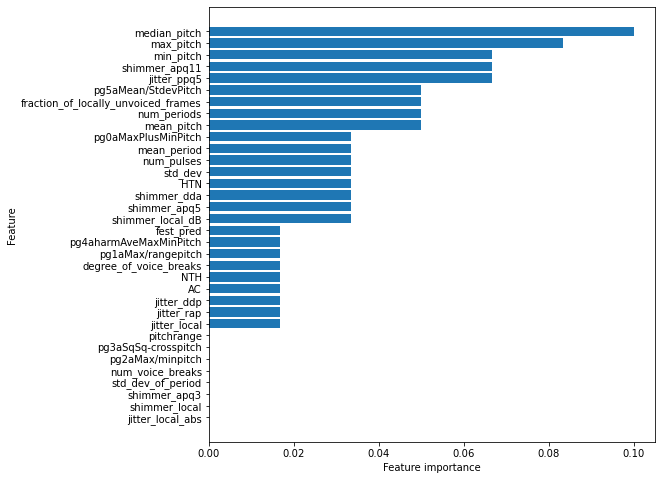

In [111]:
#best ada feature importances
display(plot_feature_importances(best_ada))
ordered_feat_imp_ada = zip_feature_importances(best_ada, scaled_df_train)
ordered_feat_imp_ada

In [115]:
gbt_clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 7,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [116]:
#GBT gridsearch:
#GradientBoostingClassifier(random_state=random_state_val)
gbt_param_grid = {
    'learning_rate':[0.1, 0.3, 1, 1.5],
    'n_estimators': [30, 50, 100, 150],
    'min_samples_split' : [1,2,3,5],
    'max_depth' :[3, 7, 10],
}
gbt_grid_search = GridSearchCV(gbt_clf, gbt_param_grid, cv=cv_def, return_train_score=True, scoring = scoring_p, verbose=verb)
gbt_grid_search.fit(scaled_data_train, y_train)

gbt_gs_training_score = np.mean(gbt_grid_search.score(scaled_data_train, y_train))
gbt_gs_training_score1 = np.mean(gbt_grid_search.cv_results_['mean_train_score'])

# Mean test score
gbt_gs_testing_score = np.mean(gbt_grid_search.score(scaled_data_test, y_test))

print(f"Mean Training Score GBT:  {gbt_gs_training_score :.2%}")#{gbt_gs_training_score :.2%} and
print(f"Mean Test Score GBT: {gbt_gs_testing_score :.2%}")
print("Optimal Parameters for GBT Grid Search (Training):", gbt_grid_search.best_params_)
print()

Mean Training Score GBT:  nan%
Mean Test Score GBT: 71.19%
Optimal Parameters for GBT Grid Search (Training): {'learning_rate': 1, 'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 150}



In [121]:

# print(f"Mean Training Score GBT:  {gbt_gs_training_score :.2%}")
# print(f"Mean Test Score GBT: {gbt_gs_testing_score :.2%}")
# print("Optimal Parameters for GBT Grid Search (Training):", gbt_grid_search.best_params_)
# print()

Mean Training Score GBT:  100.00%
Mean Test Score GBT: 71.19%
Optimal Parameters for GBT Grid Search (Training): {'learning_rate': 1, 'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 150}



With gridsearchcv on GradientBoosting, we can get accuracy score up to 100% on crossvalidation and 71% on test set (though this is the same as our un-tuned GBT model). Nice!   

Let's check out confusion matrix, etc, and feature importances there.

In [122]:
print("Gradient Boosting with GridSearch")
report(y_train, gbt_grid_search.predict(scaled_data_train), 'Train')
report(y_test, gbt_grid_search.predict(scaled_data_test), 'Test')

Gradient Boosting with GridSearch
----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       512

    accuracy                           1.00       906
   macro avg       1.00      1.00      1.00       906
weighted avg       1.00      1.00      1.00       906

--Confusion Matrix:
[[0.43487859 0.        ]
 [0.         0.56512141]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       126
           1       0.73      0.80      0.76       176

    accuracy                           0.71       302
   macro avg       0.70      0.69      0.70       302
weighted avg       0.71      0.71      0.71       302

--Confusion Matrix:
[[0.24503311 0.17218543]
 [0.11589404 0.46688742]]
----------------------

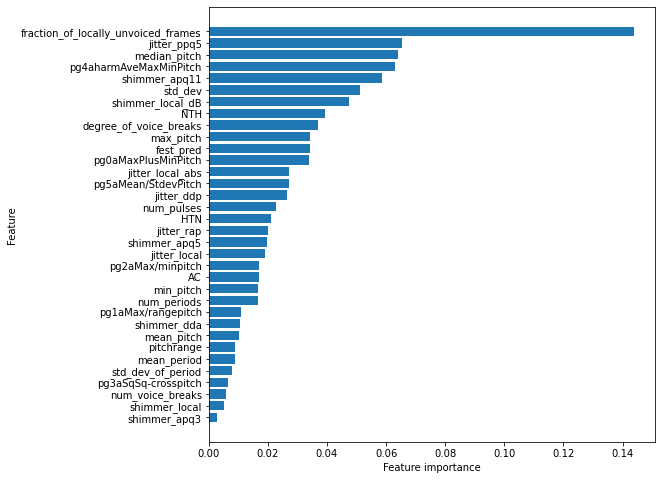

In [123]:
#make best gbt
lr = gbt_grid_search.best_params_['learning_rate'] 
md = gbt_grid_search.best_params_['max_depth'] 
mss = gbt_grid_search.best_params_['min_samples_split'] 
ne = gbt_grid_search.best_params_['n_estimators']
best_gbt = GradientBoostingClassifier(random_state=random_state_val, learning_rate=lr, max_depth=md, 
                                      min_samples_split=mss, n_estimators=ne)
best_gbt.fit(scaled_data_train, y_train)
plot_feature_importances(best_gbt)

In [124]:
ordered_feat_imp = zip_feature_importances(best_gbt, scaled_df_train)
ordered_feat_imp

[(0.002860616000072806, 'shimmer_apq3'),
 (0.005248285171530934, 'shimmer_local'),
 (0.005927275037322115, 'num_voice_breaks'),
 (0.006581833522173424, 'pg3aSqSq-crosspitch'),
 (0.007719330509107171, 'std_dev_of_period'),
 (0.00894835921554717, 'mean_period'),
 (0.008964184033391673, 'pitchrange'),
 (0.010266205687551811, 'mean_pitch'),
 (0.010503694293463293, 'shimmer_dda'),
 (0.010992943969994564, 'pg1aMax/rangepitch'),
 (0.01651018658004368, 'num_periods'),
 (0.016579115039266127, 'min_pitch'),
 (0.017000500451747336, 'AC'),
 (0.01700204231963129, 'pg2aMax/minpitch'),
 (0.01884106991978617, 'jitter_local'),
 (0.0196991220155835, 'shimmer_apq5'),
 (0.0199100589686845, 'jitter_rap'),
 (0.021023704794361515, 'HTN'),
 (0.022708868968273368, 'num_pulses'),
 (0.026372894418642653, 'jitter_ddp'),
 (0.027047967454140693, 'pg5aMean/StdevPitch'),
 (0.02718083898427315, 'jitter_local_abs'),
 (0.033767854009838755, 'pg0aMaxPlusMinPitch'),
 (0.03427090510965134, 'fest_pred'),
 (0.034332380416131

# XGBoost  
Yes, the show you've all been waiting for.  Let's see what this popular boosting model can do here.

In [128]:
from xgboost import XGBClassifier
clf = XGBClassifier(random_state=random_state_val)

# Fit XGBClassifier
clf.fit(scaled_data_train, y_train, eval_metric='logloss')

# Predict on training and test sets
training_preds = clf.predict(scaled_data_train)
test_preds = clf.predict(scaled_data_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

#recall 
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

#crossval avg
scores = evaluate_model(clf, scaled_data_train, y_train, scoring_p)
if verbose:
    print("Untuned parameters:")
    display(clf.get_params())

print("For un-optimized XGBoost, mean recall across crossvalidation:",  np.mean(scores))

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))
print()



[15:38:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Untuned parameters:


{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 7,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

For un-optimized XGBoost, mean recall across crossvalidation: 0.7251655629139072
Training Accuracy: 100.0%
Validation accuracy: 73.18%
Training Recall: 100.0%
Validation Recall: 80.11%



In [135]:
##tune parameters
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.5, 1.0],
    'max_depth': [3, 6, 12],
    'min_child_weight': [1],
    'subsample': [0.5,0.7, 1],
    'n_estimators': [50, 100, 200, 300],
}
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=cv_def, return_train_score=True, n_jobs=1 )#can update n_jobs if have access to parallel processors
grid_clf.fit(scaled_data_train, y_train, eval_metric='logloss')


xgb_gs_training_score1 = np.mean(grid_clf.cv_results_['mean_train_score'])
xgb_gs_training_score = np.mean(grid_clf.score(scaled_data_train, y_train))

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(scaled_data_train)
test_preds = grid_clf.predict(scaled_data_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)


if verbose:
    print('')
    print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
    print('Validation Accuracy: {:.4}%'.format(test_accuracy * 100))

    print('Training Recall: {:.4}%'.format(training_recall * 100))
    print('Validation Recall: {:.4}%'.format(test_recall * 100))

print('GridsearchCV (parameter optimized) mean recall: {xgb_gs_training_score1:.2%}', )#,xgb_gs_training_score, ' or '

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 200
subsample: 0.7
GridsearchCV (parameter optimized) mean recall: {xgb_gs_training_score1:.2%}


In [136]:
xgb_gs_training_score = np.mean(grid_clf.score(scaled_data_train, y_train))

# Mean test score
xgb_gs_testing_score = np.mean(grid_clf.score(scaled_data_test, y_test))

print(f"Mean Training Score XGB: {xgb_gs_training_score :.2%}")
#print(f"Mean Training Score XGB: {xgb_gs_training_score1 :.2%}")
print(f"Mean Test Score XGB: {xgb_gs_testing_score :.2%}")

Mean Training Score XGB: 100.00%
Mean Training Score XGB: 99.29%
Mean Test Score XGB: 72.19%


In [137]:
print("XGBoost with GridSearch")
report(y_train, grid_clf.predict(scaled_data_train), 'Train')
report(y_test, grid_clf.predict(scaled_data_test), 'Test')

XGBoost with GridSearch
----Report for Train set----
--Common metric scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       512

    accuracy                           1.00       906
   macro avg       1.00      1.00      1.00       906
weighted avg       1.00      1.00      1.00       906

--Confusion Matrix:
[[0.43487859 0.        ]
 [0.         0.56512141]]
------------------------------------------
----Report for Test set----
--Common metric scores:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       126
           1       0.74      0.81      0.77       176

    accuracy                           0.72       302
   macro avg       0.72      0.70      0.71       302
weighted avg       0.72      0.72      0.72       302

--Confusion Matrix:
[[0.24834437 0.16887417]
 [0.10927152 0.47350993]]
--------------------------------

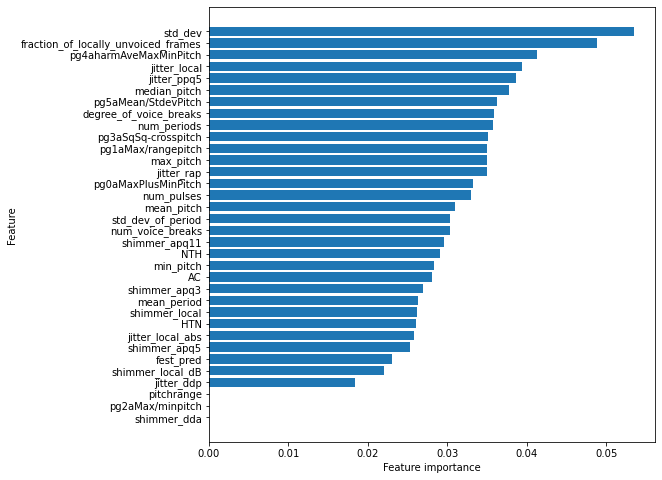

In [138]:
lr=best_parameters['learning_rate']
md=best_parameters['max_depth']
mcw=best_parameters['min_child_weight']
ne=best_parameters['n_estimators']
ss=best_parameters['subsample']
best_xgb = XGBClassifier(learning_rate=lr,max_depth=md,min_child_weight=mcw,n_estimators=ne,subsample=ss, random_state=random_state_val)
best_xgb.fit(scaled_data_train, y_train, eval_metric='logloss')
plot_feature_importances(best_xgb)
#clfbest.feature_importances_
#clf.feature_importances_

In [139]:
ordered_feat_imp_xgb = zip_feature_importances(best_xgb, scaled_df_train)
ordered_feat_imp_xgb

[(0.0, 'shimmer_dda'),
 (0.0, 'pg2aMax/minpitch'),
 (0.0, 'pitchrange'),
 (0.018326283, 'jitter_ddp'),
 (0.022080926, 'shimmer_local_dB'),
 (0.022986704, 'fest_pred'),
 (0.025311846, 'shimmer_apq5'),
 (0.025783783, 'jitter_local_abs'),
 (0.026034866, 'HTN'),
 (0.026194226, 'shimmer_local'),
 (0.026364692, 'mean_period'),
 (0.026952168, 'shimmer_apq3'),
 (0.028059063, 'AC'),
 (0.028356541, 'min_pitch'),
 (0.029079884, 'NTH'),
 (0.029547235, 'shimmer_apq11'),
 (0.030277, 'num_voice_breaks'),
 (0.03028063, 'std_dev_of_period'),
 (0.030981453, 'mean_pitch'),
 (0.033013962, 'num_pulses'),
 (0.03318146, 'pg0aMaxPlusMinPitch'),
 (0.034976717, 'jitter_rap'),
 (0.03499537, 'max_pitch'),
 (0.035019897, 'pg1aMax/rangepitch'),
 (0.035089877, 'pg3aSqSq-crosspitch'),
 (0.03569773, 'num_periods'),
 (0.035888836, 'degree_of_voice_breaks'),
 (0.03625567, 'pg5aMean/StdevPitch'),
 (0.03778989, 'median_pitch'),
 (0.038623426, 'jitter_ppq5'),
 (0.039367072, 'jitter_local'),
 (0.041235473, 'pg4aharmAveMaxMi

In [ ]:
##an old cell, used when the test set was held separate (which was not useful, since it was entirely persons with PD)
# # testing this on the actual test set
# test_df_eng = pred_eng_feat(test_df)
# #test_df_eng
# test_df_y = test_df_eng['class_info']
# test_df_x = test_df_eng.drop(['ID', 'class_info'], axis=1)
# #test_df_x.columns
# test_df_sc = scaler.transform(test_df_x)
# test_preds = best_xgb.predict(test_df_sc)


# #training_accuracy = accuracy_score(y_train, training_preds)
# test_accuracy = accuracy_score(test_df_y, test_preds)
# #training_recall = recall_score(y_train, training_preds)
# test_recall = recall_score(test_df_y, test_preds)

# print('')
# #print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

# #print('Training Recall: {:.4}%'.format(training_recall * 100))
# print('Test Recall: {:.4}%'.format(test_recall * 100))

### XGBoost results:  
XGBoost fits extremely well to training data, averaging 100% across CV and on the overall training set.  While the 100% training set accuracy might indicate overfitting, it manages about as well on test set as other models.  Test set accuracy (72%) and recall(81%) are pretty good.
Taking a look at the feature importances the top features are: std_dev(of pitch), fraction_of_locally_unvoiced_frames, pg4, jitter local, jitter_ppq5, median_pitch, pg5, degree_of_voice_breaks, num_periods, and pg1.

# Evaluating models on test_df

In [175]:
models = [logreg,
best_knn,
best_dt,
best_rf,
best_bag,
best_ada,
best_gbt,
best_xgb]

#t_X = test_df.drop(['class_info', 'ID'], axis=1)
#t_y = test_df['class_info']

##old version; when test_df was held separate as originally downloaded
# test_df_eng = pred_eng_feat(test_df)
# #test_df_eng
# test_df_y = test_df_eng['class_info']
# test_df_x = test_df_eng.drop(['ID', 'class_info'], axis=1)
# #test_df_x.columns
# test_df_sc = scaler.transform(test_df_x)
# t_X = test_df_sc
# t_y = test_df_y
t_X = scaled_data_test
t_y = y_test
testscores=[]
testrecalls = []

def eval_model_on_test(model, t_X=t_X, t_y=t_y, metric='accuracy'):
        y_preds = model.predict(t_X)
        #score_suite(t_y, y_preds)
        #print(recall(t_y, y_preds))
        if metric=='accuracy':
            return accuracy(t_y, y_preds)
        else:
            return eval(metric+'(t_y, y_preds)')
    
        
for model in models:
    r = eval_model_on_test(model, t_X, t_y)
    testscores.append(r)
    print("Results for {}: \n  {} score: {:.3}%".format(model, 'accuracy', 100*r))
    r2 = eval_model_on_test(model, t_X, t_y, 'recall')
    testrecalls.append(r2)
    print("Results for {}: \n  {} score: {:.3}%".format(model, 'recall', 100*r2))
    print('------')



Results for LogisticRegression(max_iter=500, multi_class='ovr', random_state=7): 
  accuracy score: 65.6%
Results for LogisticRegression(max_iter=500, multi_class='ovr', random_state=7): 
  recall score: 75.6%
------
Results for KNeighborsClassifier(n_neighbors=8): 
  accuracy score: 70.2%
Results for KNeighborsClassifier(n_neighbors=8): 
  recall score: 73.3%
------
Results for DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=10,
                       random_state=7): 
  accuracy score: 62.9%
Results for DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=10,
                       random_state=7): 
  recall score: 88.6%
------
Results for RandomForestClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=10, random_state=7): 
  accuracy score: 65.6%
Results for RandomForestClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=10, random_state=

Logistic Regression: logregmeanscore: 66.89%
KNN: knngs_u_trainscore: 69.8%
Decision Tree: dt_gs_training_score: 68.9%
Random Forest: rf_gs_training_score: 84.33%
Bagging: best_score_bag: 71.96%
ADA Boost: ada_gs_training_score1: 78.68%
Gradient Boost: gbt_gs_training_score1: nan%
XGBoost: xgb_gs_training_score1: 99.29%


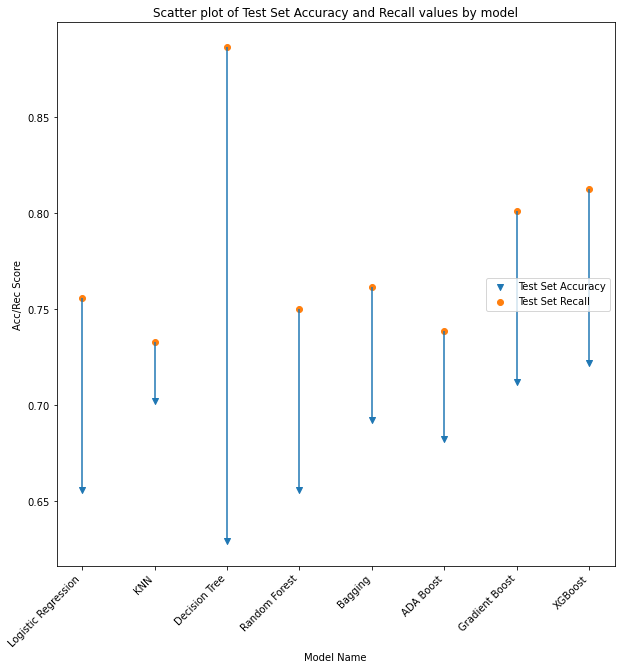

In [184]:
#recapping models crossvalidation average recall scores:
###!!! fix this graph
cvscores = ['logregmeanscore', 'knngs_u_trainscore', 'dt_gs_training_score', 'rf_gs_training_score', 'best_score_bag',
            'ada_gs_training_score1', 'gbt_gs_training_score1', 'xgb_gs_training_score1']
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Bagging', 'ADA Boost', 'Gradient Boost', 
          'XGBoost']
cvscorevals = [eval(x) for x in cvscores]

for model, scorename in zip(models, cvscores):
    print('{}: {}: {:.4}%'.format(model, scorename, 100*float(eval(scorename))))
    
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45, ha='right')
plt.scatter(models, testscores, marker = 'v', label='Test Set Accuracy')
plt.scatter(models, testrecalls, label = 'Test Set Recall')#, markersize=4

plt.vlines(models, testscores, testrecalls)

plt.title("Scatter plot of Test Set Accuracy and Recall values by model")
plt.xticks(range(0, len(testscores)), models)
plt.xlabel('Model Name')
plt.ylabel('Acc/Rec Score')
plt.legend(loc=5)
plt.show()

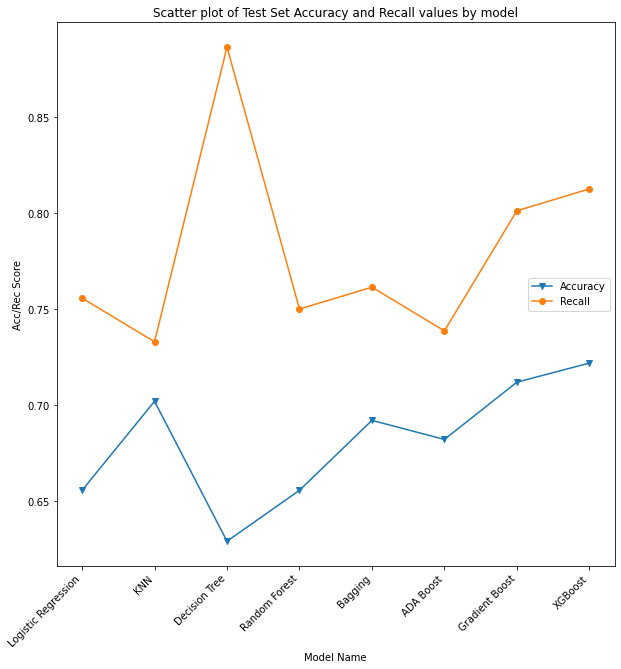

In [183]:

plt.figure(figsize=(10, 10))
plt.xticks(rotation=45, ha='right')
plt.plot(models, testscores, marker = 'v', label='Test Set Accuracy')
plt.plot(models, testrecalls, marker= 'o', label = 'Test Set Recall')#, markersize=4
#plt.Line2D(models, testscores, marker='v', )#label='Test Set Accuracy')
plt.title("Scatter plot of Test Set Accuracy and Recall values by model")
plt.xticks(range(0, len(testscores)), models)
plt.xlabel('Model Name')
plt.ylabel('Acc/Rec Score')
plt.legend(['Accuracy', 'Recall'],loc=5)
plt.show()

# Results  
The models' test set accuracy and recall scores are (respectively):
- logisticregression: 66%, 76%
- knn: 70%, 73% !!!check this - retune knn?
- decision tree: 63%, 89%
- random forests: 66%, 75%
- bagging: 69%, 76%
- adaboost: 68%, 74% 
- gradientboost: 71%, 80%
- xgboost: 72%, 81%

However, xgboost model presents a strong case, since it scored high on both accuracy and recall. We will perform the final wrap-up on that model.

# Features
Each model attributes different importance to different features, but some features which appear with high importance frequently include std_dev(of pitch), jitter, and noise-to-harmonic.   


XGBoost model, our declared best, had these top 5 features with greatest importance: std_dev, fraction of locally unvoiced frames, pg4 (harmonic avg of max/min pitch), jitter_local, jitter_ppq5.  

# Pipeline  
To share this optimized and fit model, we can assemble a pipeline to go from starting data to finish.  
NB: Results below will -not- match above results, since the same random seed is not being used (results shouldn't depend on a fortuitous seed).

In [147]:
# repasting pred_eng_feat from above for reference
# def pred_eng_feat(df):
#     '''creates the aforementioned engineered feature columns, given a dataframe'''
#     df['pg0aMaxPlusMinPitch'] = df['max_pitch'] + df['min_pitch']
#     #this potentially could be different than 2*mean, based on amount of time spent on those pitches

#     df['pg1aMax/rangepitch'] = (df['max_pitch']/(df['max_pitch']-df['min_pitch']))

#     df['pg2aMax/minpitch'] = ((df['max_pitch']/(df['min_pitch'])))

#     df['pg3aSqSq-crosspitch'] = (df['max_pitch']**2 + df['min_pitch'] **2 -2*df['max_pitch']*df['min_pitch'])

#     df['pg4aharmAveMaxMinPitch'] = ((df['max_pitch']*(df['min_pitch']))**(1/2) )

#     df['pg5aMean/StdevPitch'] = df['mean_pitch']/df['std_dev']
    
#     df['pitchrange'] = df['max_pitch']-df['min_pitch']
    
#     df['fest_pred'] = df['jitter_ppq5']*df['std_dev_of_period']
    
#     #train_df['pred_eng_feater0']O
#     #gencols = ['pg0a', 'pg1a', 'pg2a', 'pg3a', 'pg4a']
#     return df

In [148]:
# for pipeline, make class wrapper for the engineered features

from sklearn.base import TransformerMixin, BaseEstimator
#class customFeats(object):
class customFeats(TransformerMixin, BaseEstimator):
    '''object wrapper for engineered features, suitable for pipelining'''
    def transform(self, X):
        X = pred_eng_feat(X)
        return X

    def fit(self, X, y=None):
        return self
    
class dropFeats(TransformerMixin, BaseEstimator):
    '''object wrapper for column omission from training set'''
    def transform(self, X):
        dropcols = ['ID', 'UPDRS', 'class_info']
        for c in dropcols:
            try:
                X = X.drop(c, axis=1)
            except:
                pass
        return X
    
    def fit(self, X, y=None):
        return self

In [149]:
#In original approach, keeping train_df and test_df separate, this was a fresh import. 
#In revised version, combining them, I revised the method but keep this around to show the evolution of the process.
# #Fresh import of the train and test data set (to simulate a brand new dataset)
# # in order to demonstrate functionality of pipeline
# fin_train_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/train_data.txt', sep=",", header=None, names=colheadings_train)
# fin_test_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/test_data.txt', sep=",", header=None, names=colheadings_test)

# ftx = fin_train_df.drop(['ID', 'UPDRS', 'class_info'], axis=1)

# fty = fin_train_df['class_info']
# #ftx.columns

# ftx_test = fin_test_df.drop(['ID', 'class_info'], axis=1)
# fty_test = fin_test_df['class_info']

In [164]:
##new ftx / fty for new approach, combining the train/test dfs together
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=random_state_val)
#Note these are unscaled versions.
ftx = X_train
fty = y_train
ftx_test = X_test
fty_test = y_test

In [170]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

'''
Best xgb params: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 200
subsample: 0.7'''

pipe_fin = Pipeline(steps=[
    ('dropFeats', dropFeats()),
    ('customFeats', customFeats()),
    ('scaler', StandardScaler()), 
    ('XGBclf', XGBClassifier(learning_rate=lr,max_depth=md,min_child_weight=mcw,n_estimators=ne,subsample=ss, random_state=random_state_val))
    #('XGBclf', XGBClassifier(learning_rate=0.2,max_depth=6,min_child_weight=1,n_estimators=200,subsample=0.7, random_state=random_state_val))

#     ('RFclf', RandomForestClassifier( criterion='gini', 
#                                     max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=30)) 
    #random_state=random_state_val,
    #('GBclf', GradientBoostingClassifier(learning_rate=0.3, max_depth=7, min_samples_split=3, n_estimators=50, random_state=random_state_val))
    #('GBclf', GradientBoostingClassifier(learning_rate=1, max_depth=10, min_samples_split=5, n_estimators=50, random_state=random_state_val))
    ])

#    

pipe_fin.fit(ftx, fty)
# print(pipe_fin.score(ftx, fty))
# print(pipe_fin.score(ftx_test, fty_test))
#print(pipe_fin.get_params())
train_preds = pipe_fin.predict(ftx)
test_preds = pipe_fin.predict(ftx_test)
print('Recall score training:', recall( fty, train_preds))
print('Recall score test:', recall( fty_test, test_preds))

print('Accuracy score training:', accuracy( fty, train_preds))
print('Accuracy score test:', accuracy( fty_test, test_preds))


[15:31:14] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0
0.7218543046357616
Recall score training: 1.0
Recall score test: 0.8125
Accuracy score training: 1.0
Accuracy score test: 0.7218543046357616


In [168]:
import pickle
with open('clf_model_1.pkl', 'wb') as f:
    pickle.dump(pipe_fin,f)

In [171]:
with open('clf_model_1.pkl', 'rb') as f:
    unpickled_pipe = pickle.load(f)
    
print('Unpickled Accuracy:', unpickled_pipe.score(ftx_test, fty_test))

if unpickled_pipe.score(ftx_test, fty_test) == pipe_fin.score(ftx_test, fty_test):
    print('Pickled and unpickled models produce same Recall scores!')

Unpickled Accuracy: 0.7218543046357616
Pickled and unpickled models produce same Recall scores!


# Discussion  
Existing UPDRS evaluation brings in many non-speech-related factors into account; however, it doesn't establish as much specificity into speech impairment as our approach.  
The features we have identified as being most influential may be further incorporated or given more weight by physicians and speech pathologists in diagnosing PD.  Furthermore, automated analysis (like the model developed here) can identify features of voice data that humans may not identify in real-time.  

Further analysis could pursue two important extensions.  
1) Differential diagnosis.  For patients with dysphonia, the cause may be PD, but also could be caused by other neurological disorders or disorders of other systems.  In order to avoid misdiagnosing these disorders as PD, we could endeavor to expand out dataset from binary classification (PD vs healthy) to include other diseases with symptomatic crossover with PD, or which commonly have misdiagnosis issues with PD.  

2) Early diagnosis.  For many health conditions, prevention is optimal, with early diagnosis being desirable in order to apply any treatment to mitigate progress of symptoms as soon as possible.  To this end, we could expand a study to obtain voice samples over time, identifying which patients eventually develop PD, and then training models on earlier-acquired samples to identify any early-warning signs that may be missed by traditional methods.    

## Visualizations for presentation

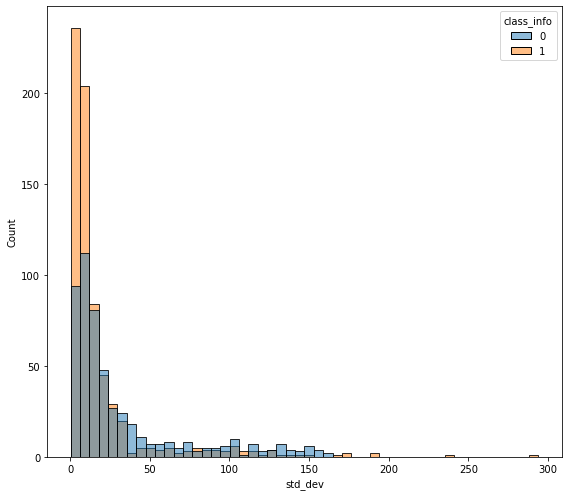

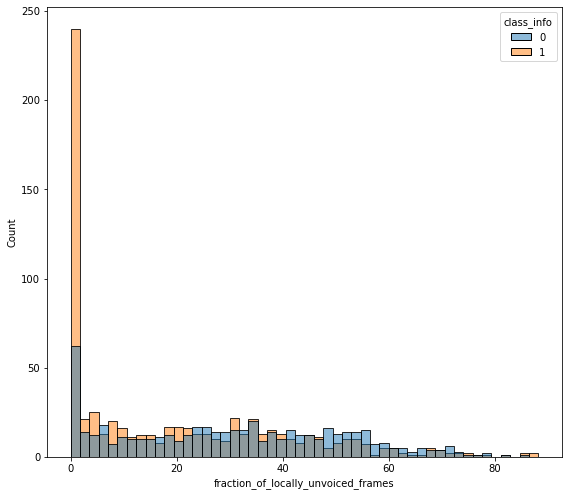

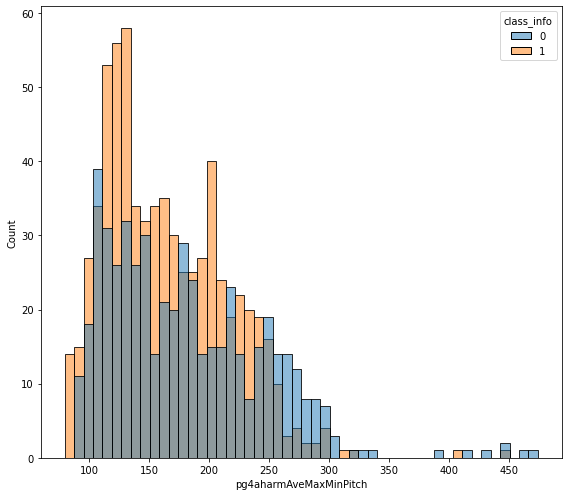

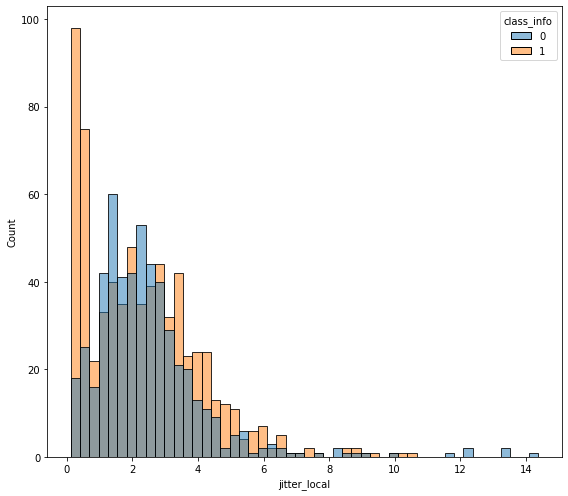

In [231]:
inspectcols = ['std_dev',
'fraction_of_locally_unvoiced_frames',
'pg4aharmAveMaxMinPitch',
'jitter_local'
]
for col in inspectcols:
    plt.figure(figsize=(8, 7))
    #sns.distplot(train_df[col], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
    sns.histplot(train_df,x=col, bins=50, hue = 'class_info' )
    plt.ticklabel_format(style='plain')
    

    plt.tight_layout()

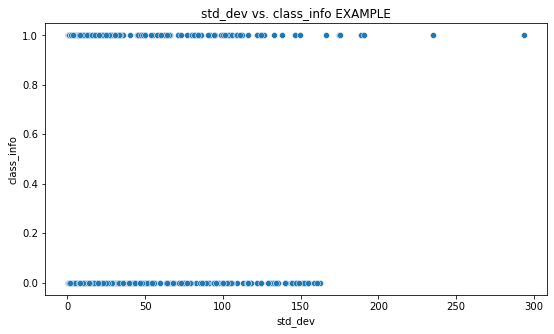

In [232]:
plt.figure(figsize=(9, 5))
col = 'std_dev'
sns.scatterplot(x=col, y=target, data=df).set_title('{} vs. {} EXAMPLE'.format(col, target))
plt.ticklabel_format(style='plain')#style='plain', 'sci', 'scientific'

Text(0.5, 1.0, 'jitter_ppq5 vs. class_info EXAMPLE')

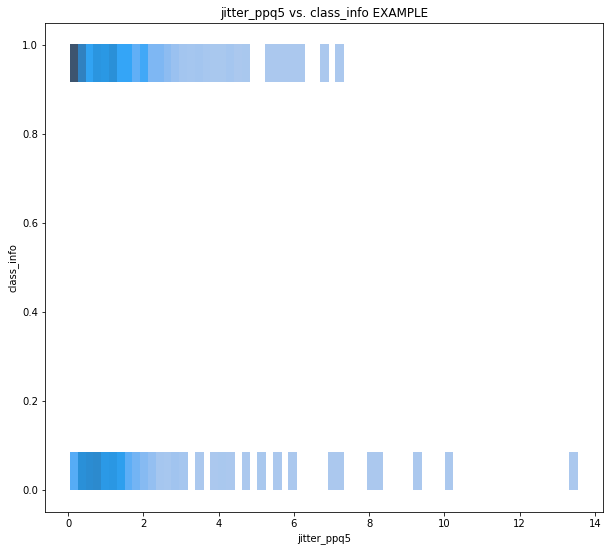

In [173]:
plt.figure(figsize=(10, 9))
sns.histplot(x=col, y=target, data=df).set_title('{} vs. {} EXAMPLE'.format(col, target))

In [236]:
##need to fix this, it's not the right approach, use an entirely different graph.
# dset = train_df[['jitter_ppq5', 'pg4aharmAveMaxMinPitch', 'class_info']]
# #dset = sns.load_dataset(dset)
# sns.catplot(x="jitter_ppq5", y="pg4aharmAveMaxMinPitch", data=dset, hue='class_info')

<AxesSubplot:xlabel='std_dev', ylabel='fraction_of_locally_unvoiced_frames'>

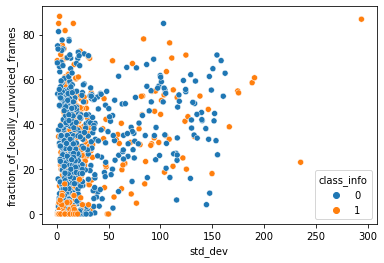

In [240]:
col1='std_dev'
col2='fraction_of_locally_unvoiced_frames'

sns.scatterplot(train_df[col1], train_df[col2], hue=train_df[target])

<AxesSubplot:xlabel='std_dev', ylabel='jitter_local'>

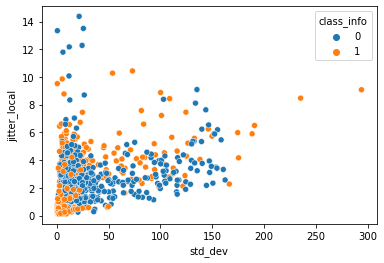

In [241]:
col1='std_dev'
col2='jitter_local'

sns.scatterplot(train_df[col1], train_df[col2], hue=train_df[target])

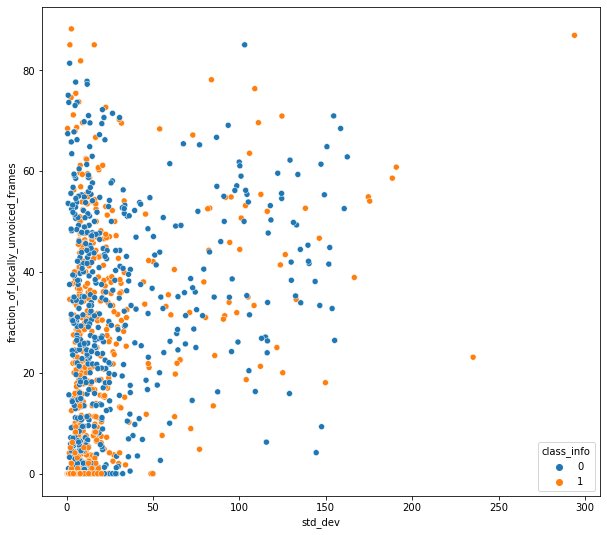

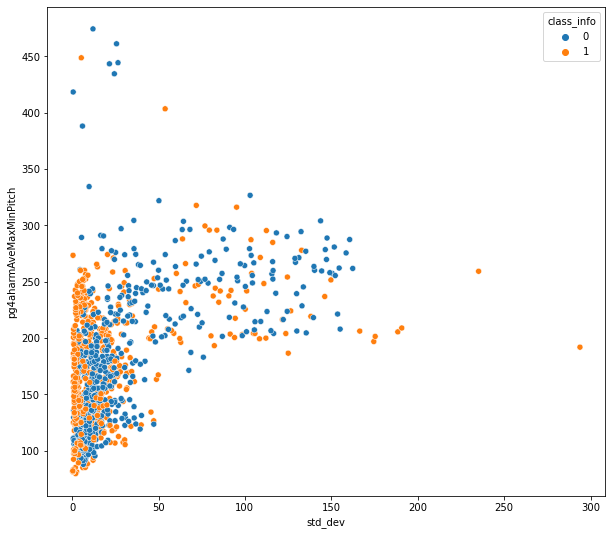

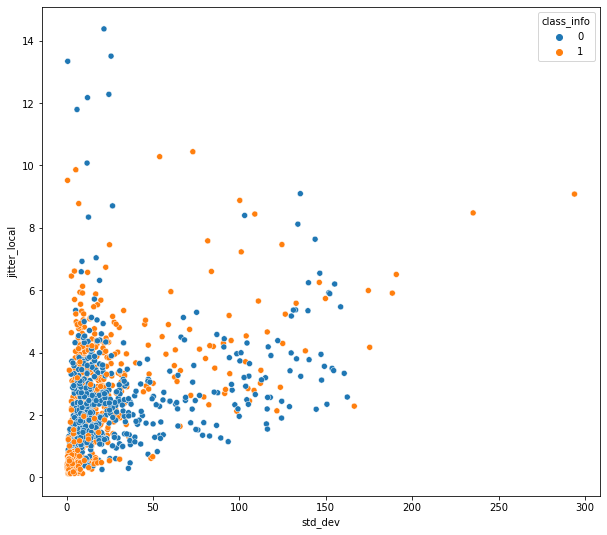

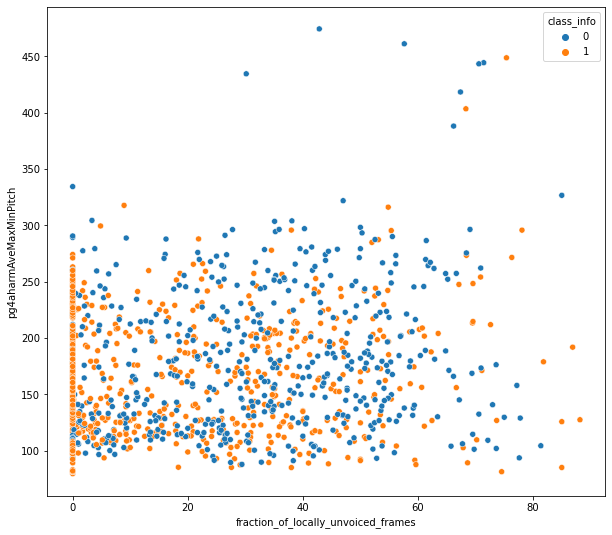

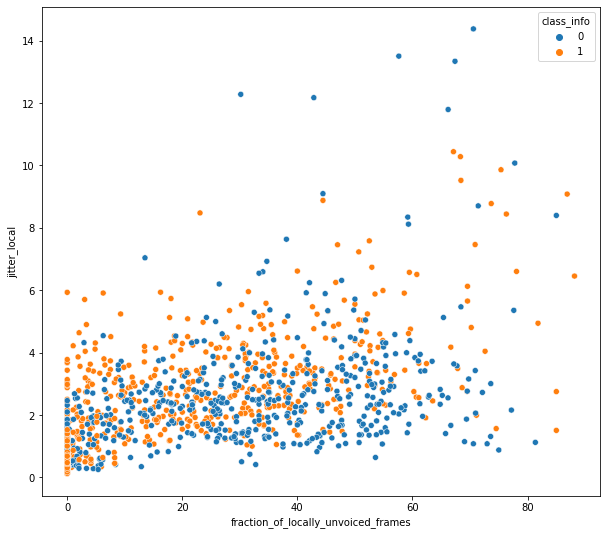

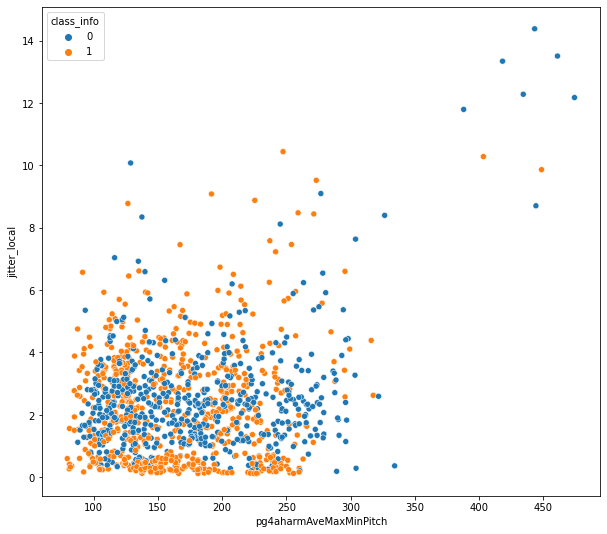

In [246]:
for i1 in range(len(inspectcols)):
    c1=inspectcols[i1]
    for i2 in range(i1+1, len(inspectcols)):
        c2=inspectcols[i2]
        plt.figure(figsize=(10, 9))
        sns.scatterplot(train_df[c1], train_df[c2], hue=train_df[target])